# Lab 2: Bag of Visual Words Image Classification

Team 3: Zuzanna Szafranowska, Claudia Baca, Quim Comas

In [5]:
import cv2
import numpy as np
import itertools
#inPython3.x:
import pickle as cPickle
#in Python2.x:
#import cPickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler,normalize, Normalizer,PowerTransformer
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import time
# from sklearn.cross_validation import StratifiedKFold



Let us first read the train and test files

In [6]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

<h1>Feature extraction, descriptors</h1>
We create detectors and descriptors: SIFT, SURF, ORB

In [7]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
SURFdetector = cv2.xfeatures2d.SURF_create(300)
ORBdetector = cv2.ORB_create()

We choose the type of local feature detector that we want to use. 

- 1 ==> SIFT
- 2 ==> SURF
- 3 ==> ORB
- 4 ==> Dense SIFT
- 5 ==> Dense SURF


In [21]:
k = 256
#codebook size
x=4
#x = input("Enter a number to choose the local feature detector: ")
L=2
#Enter the number levels of the spatial pyramid (O to L)
norm=0
#Type of normalization of 1 L2 and 2 Power, 0 if none
step_size = 5
#step size of Dense SIFT and SURF
scale=5
#scale of Dense SIFT and SURF


In [9]:
def descriptors(gray,x):
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
    if(x==4):
        kpt = [cv2.KeyPoint(x, y, scale) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SIFTdetector.compute(gray,kpt)
    if(x==5):
        
        kpt = [cv2.KeyPoint(x, y, scale) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SURFdetector.compute(gray,kpt)
    return kpt, des

In [10]:
#obsolete
def normalize(hist1):
    if(norm==1):
        hist2=np.linalg.norm(x, ord=2)
        normhist=hist1 / hist2
    if(norm==2):
        hist=np.linalg.norm(x, ord=2)

    return normhist       

<h1>BOW</h1>
We compute the indicated descriptor for all the train images and subsequently build a numpy array with all the descriptors stacked together, then we   compute a k-means clustering on the descriptor space, where we test 3 different codebook sizes k (64,128,256). And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [11]:
def Bow(train_images_filenames,train_labels):
    Train_descriptors = []
    Train_label_per_descriptor = []
    visual_words=[]
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        kpt,des=descriptors(gray,x)
        
        Train_descriptors.append(des)
        
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    if(norm==1):
        transformer = Normalizer(norm = 'l2')
        temp = transformer.fit(D)
        D = temp.transform(D)
        for i in range(len(Train_descriptors)):
            Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
    elif(norm==2):
        pt=PowerTransformer()
        temp=pt.fit(D)
        D=temp.transform(D)
        for i in range(len(Train_descriptors)):
            Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)): 
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    
    return visual_words, codebook
    
    
    

In [12]:
start = time.time()
visual_words,codebook=Bow(train_images_filenames,train_labels)
end = time.time()
print('Time: {}s.'.format(str(end-start)))

<h1>Bow-Spatial Pyramid</h1>
We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [15]:
def get_spatialpyramid(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        i=0;
        Train_label_per_descriptor.append(labels)
        hist =[]
        
        for l in range(L+1):
            if(l==0):
                kpt,des=descriptors(gray,x)
                codebook.fit((des))
                words = codebook.predict((des))
                visualwords = np.bincount(words, minlength=k).reshape(1,-1).ravel()
                print(words)
                hist.append(visualwords)
        
            else:
                print (l)
                wstep=np.int(gray.shape[0]/(2*l))
                hstep=np.int(gray.shape[1]/(2*l))
                
                for u in range(0,gray.shape[0],wstep):
                    for f in range(0,gray.shape[1],hstep):  
                        kpt,des=descriptors(gray[f:f+hstep, u:u+wstep],x)
                        words = codebook.predict((des))
                        visualwords = np.bincount(words, minlength=k).reshape(1,-1).ravel()
                        weight = 2**(L-l)
                        
                        print(visualwords)
                        hist.append(weight*visualwords)     
return hist
                        

In [16]:
Train_descriptors = []
Train_label_per_descriptor = []
visual_words=list
hist=[]
k = 256
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)

for filename,labels in zip(train_images_filenames,train_labels):
    
    hist=get_spatialpyramid(train_images_filenames,train_labels);
        
    visual_words=(hist)
    
        
            

[120 120  78 ... 186 186 186]
1
[ 0  0  0  0  3  8  0  2  6  0  0  7 14  4  7  9  5  0  0  1  0  7  8  1
 23  5  0  0  0  0  1  2  0  1  7  1  6  0  0  0  0  1 18 15  3  5  3  0
  0 10  0  7  0  0  0  0  8  0  4  5  0  6  7  0  0 13  2  2  6  0  3  0
  6  4 16  0  7  1  5  0  0  0  4  2  9  0  0  5  2  4  1  0  2  0  5  0
  0  0  6  5  0  8  0  5  2  1  0  0  0  0  0  0  9  3  5  0  0  0  4  0
  9  2  0 13  3  0 10  8  0  0  8  8  2  0  0  2  0  0  0  0  0  1 10  8
  2  0  1  0  0  5 11 15  5  0  1  1  7  0  1  1  0  6  0  0  5  0  2  1
  6  0  0  2  0  0  0  0  4  0  0  2 10  2  0  1  0  5  0  0  0  5 12  7
  9  0  0  2  1  4  1  4  0  0  9  0  1  0  1  0  0  0  0  5  0  0  0  1
  0  0  0  0  5  4  0  3  0  0  5  5  0  4  0  0  7  2  1  3  0  0  0  0
  0  0  0  0  0  0  0  6  0  4  2  2  2  6  4  2]
[ 3  4  8  6  1  3  7  0  6 12  0  3  0  0  0  7  0  0  7 11  0  0 10  0
  0  7  0 20  0  7  4  0  0 17  0  6  3  0  1  3  0  0  0  0  0  1  7  0
 13  0  6  0 22  0  5  0  0  1  0  6  8  0

[ 40  31  31 ... 189 189 189]
1
[ 0  0  0  0  0  0  2  0  0  0  4  5  0  0  8  0  6  5 11  0  3  0 33  0
  4  1  0  0  2  0  4 19  7  0  3  0  4  0  0  1  8  0  4  0  0  6 33  7
  0  0  0  0 10  8  2  2  4  0  0  0  6  0  0  0  3  0  0  2  1  2  0  3
  0  9  6  0 10  0  1  0  0  3  9  0  3 10  3  5  0  0  0  1  0  9  1  7
  2  0  0  0  5  0  6  0  0  0  5  6  0  0  0  0  3  3  1  0  0  5  0  0
  0  5  0  0  3  1  1  0  6  0 17 30  3  9  0  4  6  0  5  3  0  0 10  0
  0  8  0  2  0  4  0  0  0  6  5  5  0 11  2  0  3  0  5  0 17  0  0 17
  0  0  0  0  2  0  0  0  3  7  7  0  0  0  0  1  0  1  0  0  3  0 26  0
  0  0  0  0  0  8  5  0  0  0  1  0  0  2  5  3  4  0  0  0  5  2  2  0
  0  0  6  0  4  0  6  0  0  0  2  0  7  2  0  0  0  1  3  5  0  0  0  5
  0  5  2  1  0  0  0  5  0  2  6  0  0  0  0  3]
[ 1  0 19 29  9 26 12  3 17  4  0  0  6  0  0  0  0  0  0  8  0  0  0  8
 11  9  0  0  3  0  0  0  0  4  0  6  0  5  0  0  0  0  0  7 12  0  0  0
  9  0  0  7  0  0  0  2  0  0 11  8  0  0

[ 7  7  7 ... 41 41 41]
1
[ 3  0  6  0  0  0  0 19  5  0  0  1 19  7 70  2  0  0  1  0  4 13  5  1
 10  0  0  0  0  6  1  3 17  0  1 10  0  4  0  2  0  0 10  0  0  0 13  0
  0  1  2  0  0  3 26  4  6  8  0  0  0  2  0  0  2  0  0  0  4  0  0  0
  3  0  2  1  0 20  2  0  2  0  5  0  0  6  0  0  6  0  5  4  0  0  1  3
  8  1  6  0 13  1  4  0  0  1  0  0  3  6  4  6  0  0  2  0  0  1  0  0
  0  0  1  1  0  3  5  0  6  8  0  2  5  0  5  5  5  0  0  2  0  0  0  2
  0  0  0  0  5  2  0 11  2  0  0  1  1  1  3  0  4  0  0  2 17  4  0  0
  0  6  6  0  2  0  6  0  0  4  0  6  0  0  0  0  3  7  0  9  1  1  9  0
  5  1  1  0  0  0  0  0  0  1  0  8  0  0  6  6  0 10  0  0  4  2  0  0
  0  0  3  1  0  0  0  0  0  0  0  0  0  4  1  0  0  0  0  0  0  0  3 18
  8  2  5  0  0  1  1  0  3  8  4  0  0  0  0  0]
[ 2  7  0  0 10  3  8  0  0  0  9  0  0  0  0  2  0  7  1  6  3  0  1  0
  2  0  5 10  3  0  2  0  0  8  3  0  0  4  0  0 22  9  1 14  0  0  0  2
  2  6  4  1  0  0  0  0  6  0 14 15  0  0  0  0

[  7   7   7 ...  56 191 191]
1
[28  0  6  0  3  1  0  6  0  0  0  6  0  1  0  0  0 10 13  3  6 12  9  0
  0  5  0  1  0  0  3  3  1  0  0 39  0  0 10  0  9  0  0  3  0  0  0  0
  8  5  0  0  5  0  0  3  0 14  0  7  0  2  0  0  0  0  0  2  0  7  0  8
  3  6  0  0  0  4  0  3  4  0  0 19  0  0  8  8  5  0  0  0  7  0 20  1
  2  0  5  0  5  7  5  0  8 12  8  3  0  0  0  5  0  4  0  0  0  4  0  0
  0 28 22  0  0  9 15  0  0  0  5  0  0  0  0  0  0  0  5  9  6  5  0  0
  9  0  0  5  0  0  0  0 20  0  0  0  1  0  0  2  0  1  0  0  0  0  4  0
  0  0  0  3  0  0  0  3  0  0  0  1  0  0  0  0  5  4  0  7  0  0  0  0
  0  0  2  0  1  0  0  0  0  0  0  8  0  0  1  0  0  0  5  3  0  6  3  0
  0 24  0  7  6  2  3  0  0  0  5  0  0  0  5  0  0  3  0  0  2  0  2  0
  0  0  6  0  0  0  0  0  2  2  8  0  1  0  5  0]
[ 0  4  5  0  0  8  1 10  0  5  7  0  4 10  6  0  9  0  0  0  0  0  0  9
  6  0  3  6  0  5  0  4  0  0  0  0  1  1  4  1  0  7  1  0  0  0  6  4
  0  7  0 11  1  7  4  4  1  0  1  0  0  1

[0 0 0 6 0 0 1 0 3 0 0 0 3 1 3 0 0 0 0 0 0 0 0 3 0 0 0 2 0 0 0 0 0 0 0 0 2
 0 0 1 0 7 1 0 0 9 1 0 0 0 0 0 0 3 0 0 2 0 4 0 0 0 0 0 1 2 9 0 0 0 0 0 0 0
 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 5 0 0 0 1 0 0 0 0 0 1 3
 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 4 0 0 0 0 0 0 0 0 4 0
 0 5 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 0
 0 1 0 0 0 0 3 0 5 0 0 0 0 0 0 0 5 4 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 0 0 0 1
 0 2 1 0 0 0 0 0 0 0 3 0 0 0 0 4 0 0 0 0 0 3 4 0 0 0 0 0 0 0 0 0 0 6]
[195 195 195 ... 206  92  92]
1
[ 0  0  0  5  2 13  0  0  0  0  2  2  9  6  1  0  0  0  0  0  0  0  0  0
  5  2  2  5  9  2  4  0  0  8  0  3  0  7  0  0  0 13  1  3  0  4  7  4
  0  0  0  0  5  0  0  1  2 12  0  0  0  8  8  0  0  0  0  3  0  0  0  1
  1  0  7  2  9  4  0  0 10  0  3  5  7  6  4  0  9  0  0  1  0  0  4  2
 12  5  5  0  4  2  0  1  2  0  9  0  3  0  0  0  7  2  0  1  4  3  1  2
  3  0  1 14  0  0  0  6  0  4  3  1  7  0 11  9  7  0  0  0  0  3  1  6
  4 10  0 

[196 196 196 ... 242  39  39]
1
[ 15  25   0   0   0  14   0   0   0  24   0  26   0   0   0   0   0   0
  24   0   0   0   0   0   0   0   0   0 252   8   0   0  17   0   0   0
   0   0   0   2   0   0   2   0   0   0   0  19   0   9  19   0   0  19
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  24   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  57   0   0  14   0   0   2   0  11   0   0   0   0   0   0   0   0   0
   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   9
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  17   0   0   0   0   0   0   0   0   0   0  24   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0
   0   0   0   0   

[ 0  0  0  0  0  0  0  0  0 10  0 13  0  0  0  0  0  0 12  0  0  0  0  0
  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  6
  0 13  8  0  0  6  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0
  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  3
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  6  0  3  0  0  0  0  0  0  0  0  0  0  2  5  0  0 10
  3  0  0  0  0  0  0  5  0  7  0  0  0  0  0  2  0  2  1  0  0  0  0  0
  0  0  0  6  0  0  1  4  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 

[ 0  0 11  0  0  0  2  7  5  0  2  0  0  0  0  1  0  0  0  0  0  0  0  4
  0  0  0  0  8  0  0  0  0  1  0  0  0 14  0 11  1  0  0  0  0  0  0  0
  0  0  0  5  0  0  0  0  2  0  0  2  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  0  1  0  6  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 11  0  4  0  0  0  0  0  1  3  0  0  0  0  0  0  3  0  0  0  0  0  0
 11  0  0  0  0  0  0  0  0  0  0  9  0  0  1  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  3  0  0  3  0  0  0  0  0  0  0  1  0
  0  2  0  0  0  0  0  0  0  2  0  0  0  0  0  0  4  0  0  0  0  0  0  0
  0  0  0  6  0  0  0  1  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  3  0  0  0  0  0  0]
[ 2  0  0  0  0  1  0  0  0  0  0  0  0  5  0  0  4  0  0  4  0  0  3  0
  0  3  0  0  0  0  1  1  0  0  0  0  3  0  2  0  1  0  1  0  0  0  0  0
  0  0 12  0  0  0  0  6  1  2  1  0  0  0  0  0  0  0  2  0  2  0  0  0
 

[ 1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0
  4  0  0  0  0  0  0  0  0  0  0  2  0  0  1  0  0  0  0  1  0  0  0  0
  0  0  0  0  0  0  0  0 11  0  1  0 13  0  0  0  0  0  0  0  0  1  3  0
  0  0  0  5  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  9  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0
  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  1
  0  0  3 10  1  0  0  0  0  0  3  5  0  0  0  0  0  0  0  0  0  0 11  0
  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  4  0  0  3  2  0  0  3  0  0  4  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0 23  0  2  4  0  2
  0  0  0  0  1 19  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  2
  0  0  0  0  0 17  0  0  0  0  0  0  0  0 14  0  0  2  0  0  1  0  0  0
 

[123 159 159 ... 197 200 200]
1
[ 8  0  0 11  0  0  4 14 10  0  0  1  0  0  3  0 10  1  9  0  4  0 15  0
  0  0  0  0  4  0  0  9  0  2  5  2  5  0  0  0  8  7  0 13  2  0  0  6
  0  0  0  0  8  2  0  0  5  5  6  6 15  4  6  0  3  0  3  9  0  0  0  3
  6  7  0  3  9  9  4 12  0  0  0  4  0  0  0  5  0  6  0  5  0 17  0  0
  0  0  7  9  6  0  0  3  9  0  5  6  0  0  0  0  2  0  0  6  0 12  0  0
  5  0  5  1  4  4  0  8  1  0  0  5  6  8  9 10 10  0  0  0  6  5  0  0
  9  1  4  0 11  0  0  0  0  4  0  6 14  0  0  3  0  0  0  0  8  0  3  0
  0  0  5  0  1  0  0  6  2  0  0  0  0  0  0  0  3  0  0  3  3  0  0  7
  9  6  0  0  6  0  0  3  0  0  7  0  4  0  0  0  0  4  0  3  3  0  0  0
  4  3 11  4  5  4  7  0  0  6  0  0  5  0  5  0  0  2  2  0  0  0  0  0
  0  4  0  0  0  0  6  0  0  0  0  0  3  0  0  0]
[ 0  5  7  0  6 11  0  0  4  2 18  0 15  7  0  5  0  0  0  0  0 11  0  2
  0  7  0  0  0 13  0  0  0  0  0  0  0 17 15  0  0  0  2  1  0  8  7  0
  0  6  2  7  0  0  0  0  1  0  0  0  0  0

[2 0 0 0 0 0 5 0 5 0 0 0 0 0 3 0 0 0 0 7 0 0 5 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 1 5 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 0 0 4 0 3 2 1 0 1
 0 0 0 4 0 0 0 0 1 3 0 0 2 8 2 0 0 0 0 3 0 0 0 9 0 0 5 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 8 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0
 6 0 0 0 1 0 3 0 0 0 0 0 1 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 1 0
 0 1 2 1 1 0 0 7 0 3 0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 3 0 3 0 2 0 2 1 0 5 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
[ 0  0  2  0  0  4  0  0  3  0  0  0  0  1  0  0  0  0  0  0  0  0  1  2
  1  2  0  0  0  0  0  0  0  0  0  0  0  1 11  0  0  0  0  0  0  4  3  0
  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  0  0 11  0  0  0  0 15  0  0  0  0  0  4  0  4  0
  0  0  0  0  5  2  0  0  0  0  0  0  0  0  0  0  0  0  3  0  2  0  0  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  5
  0  0  0  0  0  0  1  3  0  0  0  0  0  0

[0 0 0 0 0 0 0 0 0 0 0 0 4 2 1 0 0 0 3 1 0 1 0 0 5 0 0 0 0 0 0 0 1 0 4 0 0
 5 0 0 4 0 0 8 3 0 0 0 1 0 0 0 2 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0
 4 1 4 3 0 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 1 3 0 1 0 0
 0 6 0 0 0 0 0 0 7 0 0 5 0 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 5 0 0 2 0 0 0
 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0
 1 0 2 4 1 3 0 2 0 0 0 0 0 1 0 0 7 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 2
 0 0 0 2 0 0 2 7 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 2 2 0 2 0 2 0 0 0 0 0]
[ 0  4  5  0  3  0  0  1  1  0  0  3  0  0  0  0  0  0  0  0  1  0  4  0
  0  0  0  0  0  0  0  1  0  0  0  0  4  0  3  3  0  0  1  1  0  6  0  0
  0  0  0  0  0  2  0  2  0  0  0  0  0  0  8  0  0  0  0  0  3  0  0  0
  0  0  0  0  0  0  0  2 12  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  5  0  0  0  0  0  5  0  0  1  0  0  1  0  0  0  0  0  0  3  0
  0  0  0  0  0  1  0  0  0  0  1  0 10  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  5  1  1  0  0  1  0  0  0  0  0

[ 0  0 18  0  0  0  0  4  0  7  0  0  8  0  0  0  0  0  0  0  0  0  0  0
  5  0  0  0  0  0  0  0  3  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4 17  0  0  0
  0  0  0  0  0  0 12  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  9  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  0  2  0  0  0  0 11  0  0  4  0  0  0
  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  2  6  0  0  0
  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  8  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  6  0  0  0  0  0  0 14  0  0  4  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 15  0  0  0  0  4  0  0  0  0  0  0  0  0  9
  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  4
  0  0  3  4  0  8  1  0  0  2  3  0  0  1  0  0  2  0  0  6  2  0  5  0
  2  3  0  1  0  0  1  0  3  0  0  0  0  0  3  0  1  0  6  0  0  0  0  0
  0  0  0  0  0  2  0  0  0  0  0  0  0  4  0  0  0  0 14  0  0  0  0  1
  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0
  0  9  0  0  1  1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1
  0  0  0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  6  4
  0  0  2  0  0  0  0  2  0  0  1  0  0  2  0  0  0  0  0  0  0  0  0  6
  0  0  6  0  0  0  2  0  0  0  0  5  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 3 1 0 0 0 0 2 0 0 3
 2 0 0 0 3 0 4 1 0 0 5 0 0 6 2 0 0 1 0 1 0 3 0 0 0 0 1 4 5 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 4 0 6 0 3 0 0 0 5 3 0 0 0 0 0 1 0 0 0 0

[ 0  0  1  2  0  0  2  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  2
  0  0  3  0  0  1  0  0  0  0  0  0  0 10  2  0  0  0  0  0  1  0  0  0
  2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  2  0  3  0  0  0  1  0  0
  2  4  6  0  0  0  0  0  0  0  0  1  0  4  0  0  0  0  8  0  1  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0
  7  5  2  0  0  0  0  3  0  0  0  1  0  0  0  2  2  0  1  0  1  2  0  2
  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4
  0  7  0  0  0  0  0  2  0  0  0  0  0  2  0  1  0  2  0  2  4  0  0  0
  0  0  0  0  1  0  0  0  0  1  1  0  0  0  5  1  0  0  3  0  3  0  0  6
  2  0  0  0  1  0  0  0  1  3  0  0  0  0  1  0  0  0  0  0  0  0  1  0
  0  0  2  0  0  0  2  0  0  6  0  2  5  0  0  0]
[0 0 0 0 1 7 0 0 0 0 0 8 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 4 0 1 7 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 5 0
 0 0 0 0 3 1 0 0 3 1 1 0 2 0 3 2 0 0 0 0 7 0 0 1 0 0 3 1 3 1 0 0 1 0 3

[ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  1  2  0  2 13  0  0  0
  2  0  0  0  0  0  4  3  0  1  0  0  0  5  0  3  0  0  0  1  0  0  0  0
  0  0  3  3  0  3  3  0  0  0  0  3  0  0  0  0  2  0  0  0  6  0  0  0
  0  3  0  0  0  0  0  3  0  0  0  0  2  0  0  0  0  2  1  0  1  0  0  0
  0  0  0  0  0  0  0  1  2  0  1  0  0  0  0  0  0  0  0  1  1  0  3  3
  0  0  0  0  0  0  0  0  0  0  2  0  4  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  4  0  0  0  0  1  0  0  0  1  0  2  1  0  0  0  0  0  0  0  0
  0  2  0  0  0  0  0  0  0  3  0  3  0  0  3  0  0  2  0  1  1  0  0  0
  0  0  0  0  0  4  3  0  1  0  0  0  0  0  0  0  2  3  0  0  0  1  3  0
  0  1  0  3  0  0  3  0  0  0  0  0  0  3  0  0  0  0  1  4  3  0  0  0
  0  0  0  1  0  6  0  3  0  0  4  0  0  0  0  4]
[ 0  0  0  0  0  2  0  0  9  0  0  0  0  0  4  1  0  0  0  0  0  0  0  3
  0  3  0  0  5  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  3  0
  9  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  3  4  3  1  1  0  3
 

[ 0  0  0  0  0  0  8  0  2  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0
  0  0  0  0  0  0  0  0  0  0  9  0  0  2  0  0  0  0  5  0 10  0  0  4
  2  0  0  4  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  1  0  1  0  0
  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  1
  3  0  0  0  0  0  0  0  0  0  0  1  0  0  3  2  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  2  0  0  0  0  0  0  0
  0  0  2  0  0 12  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0
  1  1  0  0  0  6  4  0  1  0  0  0  0 11  0  0  0  1  2  0  0  0  4  0
  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  3  0  3  0  0  0  0
  0  0  0  0  2  1  3  0  0  1  3  0  0  0  0  0  0  2  0  0  1  2  0  0
  0  1  0  0  0  1  0  0  0  0  0  0  0  3  0  4]
[2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 5 0 0 0 0 0 0 4 8 1 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 4 0 0 4 0 0 0 0 0 5 0 0 0 0 8 0 0 7 0 0 0 0 3 0 0 5 0 0 4
 0 1 6 0 0 0 0 0 0 2 0 0 0 2 3 0 0 3 3 0 2 0 0 0 0 0 0 0 3 0 0 0 0 2 0

[ 2  3  0  0  0  0 10  0  0  0 11  2  0  0  0  0  0  0  0  0  0  0  0  1
  0  1  0  0  0  0  0  0  0  0  0  4  5  0  4  0  0  1  0  0  0  0  5 11
  0  0  0  0  1  4  0  1  2  0  0  0  0  0  0 11  8  0  0  0  4  0  0  1
  0  0  0  3  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  0  0  2  0  0  0  3  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  5  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  5  1  0  0  0  0  5  0  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  3  0  0  0  0  0  0  0  3  0  6  0  0  0  0  0
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2  0  0 15  2  0  0  0  0  2  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  4  0  0]
[0 0 0 0 8 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 1 0 3 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 9 0 0 0
 0 0 0 0 0 3 2 0 0 0 0 5 0 0 1 0 0 0 2 2 0 0 0 0 7 2 0 0 6 0 0 2 0 4 0

[ 0  0  1  0 11  0  0  0  0  0  1  0  1  5  0  0  0  0  0  5  0  0  0  7
  0  3  2  0  0  0  0  0  2  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  7  2  0  0  0  0  3  4  0  0  1  1  0  0  0  0  1  4
  1  0  1  0  0  0  0  0  0  4  0  0  1  0  0  0  0  0  0  0  0  0  1  0
  0  3  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  1  2  0  0  4  0  0
  8  0  0  1  0  0  0  1  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  3  0  1  0  0  0  0  2  0  0  0  2  2  0  0  0  2  0  0  0  0
  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  1  3  0  1
  0  0  0  0  1  0  0  0  0  0  5  0  0  0  6  0  1  0  3  0  0  3  0  2
  0  0  1  0  4  4  0  0  0  0  4  0  0  0  0  0  0  0  0  7  0  0  0  0
  0  0  1  0  2  0  0  0  0  0  0  0  0  0  6  0]
[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 4 0 0 0 0 0 8 0 0 7 3 0 0 0 0 0 0 2 0 0 2 0
 3 0 0 2 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 6 4 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0
 0 1 0 3 0 0 0 0 0 3 0 3 0 0 6 0 1 0 0 2 0 0 0 0 6 0 0 0 2 0 0 0 0 0 2

[ 0  2  0  0  0  0  0  0  2  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0
  0  8  0  2  0  0  0  0  1  3  5  2  0  0  0  0  0  0  0  0  0  0  7  0
  5  0  4  1  0  0  7  0  1  0  0  3  9  0  0  0  0  2  0  0  0  0  0  0
  0  0  3  0  0  0  0  0  2  1  0  0  0  0  0  0  5  1  0  0  0  0  1  0
  0  0  6  0  0  0  2  0  0  0  0  0  0  0  3  0  0  2  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  6  0  2  0  0  0  0  0  1 10  0  1  0  0  0  5  0  0  0  0  0  8  0
  0  0  0  1  0  0  8  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0
  0  0  1  0  0  0  1  3  0  1  0  0  2  0  0  0  0  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  3  1  0  0  1  0  0  1  3  0  0  0  0  0  2  0]
[ 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  2  1  0  0  0  0  0  0  4  0  1  1  1  0
  0  0  0  0  0  0  0  0  0  6  0  5  5  0  5  3  0  0  0  5  0  0  0  0
 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 3 4 0 0 0 3 0 0 0 0 4 0 0 0 0 0 1
 0 0 4 0 0 0 0 0 0 7 0 0 0 0 0 3 3 0 0 3 0 2 7 0 0 0 0 0 3 0 0 0 0 3 0 5 0
 0 0 0 0 0 3 1 0 0 7 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3 0 0 0 0 4 0 0 0
 1 0 1 0 8 0 2 0 0 0 3 0 2 0 0 0 2 1 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 1 0 2
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 3 0 0 0 0 0 0 0 6 4 5 5
 0 0 0 1 0 2 0 4 0 0 0 0 0 0 0 3 0 1 0 0 4 0 0 0 0 0 0 0 0 0 4 0 2 0 0 0 0
 0 2 0 1 0 0 0 0 7 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
[ 2  0  0  0  0  0  0  0  0  0 12  0 10  0  0  0  0  1  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0 16  0  0  0  0 13  0  0  0  0  0  2  0  0  0
  0  0  0  0  0  0 10  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 13  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0 20  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0

[ 0  0  0  0  0  0  0  0  0  4  0  0  0  2  0  0  0  0  0  6  0  0  3  8
  0  0  0  0  0  0  0  0  2  0  0  0  0  0  3  0  0  4  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  4  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  6  7  0  0  0  0  0  0  0  3  0  0  0 10
  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  6  0  0  0  0  0  2  0  0  0  0  1  0  0  2  0  0
  0  1  0  0  0  0  0  0  0  9  0  0  3  0  0  0  4  0  0  0  3  0  6  5
  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  3  0  0  2
  8  0  0  4  0  0  0  4  0  5  0  0  0  0  0  0  0  0  0  0  0  7  0  0
  0  0  0  0  0  0  0  5  0  0  0  0  1  0  0  0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0
 0 0 0 0 0 0 0 0 0 7 0 2 3 0 0 0 5 0 5 0 0 1 0 0 0 1 5 1 0 0 0 0 5 5 0 0 2
 0 0 0 0 0 0 0 0 0 0 4 0 0 2 0 4 3 0 2 0 0 0 0 0 0 0 0 0 4 0 0 8 0 0 0

[  7   7   7 ...  13 213 213]
1
[15  0  0  1  0 12  1 26  4 24 10  0 28  0  0 14  0  0  0 28  0  0  0  0
  0  0 17  0 11  0  0  0  0 26  0  3  0  0  0 20  0  0  0  0 23  0  7  0
  0  0  1  0  0  0  0  5  4  0  0  0  1  0  6  0  5  0  0  1  3 17  3  1
  5  9  7  0  0  3  0  0  0  9  5  6  0  1  2  0  1  0  0  0  0  0  5  2
  0  0  0  0  0  0  7  0  0  7  0  4  0  0  0  0 16  0  0  0  0 19  0  0
  0  0  0  0  3  0  4  0  0  5  0  0 31  6 29  0  0  4  0  0 19  4  0  3
  0  3  0  0  0  0  2  0  0  0  1  7  1 10  0  9  0  0  6  2  0  1  0  0
  0  0  0  0  0  0  0  0  0  0  0  2  0  0  5  0  0  3  7  4  0  0  2  0
  0  0  9  0  0  0  0  0  0  0  0  0  4  1  0  0 14  2  0  0  0  0  0  8
  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0 11  0  0  0  0  1  0  0
  0  7  4  0  0  0  0  7  0  0  0  0  0  4  4  0]
[ 0  5  0 10  4  0  6  0  1  0  0 10  0  3 12  0  8  1  0  0  0 10 11  8
  0  0  0 15  0  0  5  0  3  0  0  0  6  4  7  0  4  0  7  4  0  8  0  0
  3  0  4  6  1  0  0  4  0  7 15  5  8  7

[118 118 135 ... 242 242 200]
1
[12  0  0  0  0 22  3  4  0  4  4  0  5  0  0 11  0  0  0 20 15  9  3  0
 11  6  4  0  0  4  0  0  2  1  0  3  0  0  0  3  6 15  0  3  9  0  0  0
  0  0  0  0 23  8  0  0  0  0  0  9  6  3  6  1 10  0  0 18  0  5  0  8
 10  0 21  5  7  0  0  0  0  0  7  6  0  0  0  0  0  0  0  6  0  0  0  0
  0  2  6  0  0  0  0  0  0  6  0  0  0  0  0  0  0  7  0  0  0  0  4  0
  4  2  5  0 12 12  0  0  4  4  0 12 15  1  0  5  2  0  0  5  0  8  0  0
  0  0 10  2  0  0 12  0  0  3  7  0  0  0  0  4  0  0  4  0  0  6  6  0
  0  0  0  0  0  1  5  9  5  0  0 10  0  0  0  0  0 10  0  3  0  0  0  0
  2  0  1 10  5  0  0  0  0  0  0  0  0 13  0  0  7  2  8  7  0  0  0  0
  0  4  0  0  0  0  5  0  0  4  0  4  9  0  0  0  0  0  1  8  0  0  0  1
  0  5  0  0  0  0  0 10  0  2  0  0  3  0  6  8]
[ 0  8  0 11  5  0  0  0 12  2  0 15  0  9  9  0  0  0 16  9  0  0  0 10
  0  0  2 18  2  0  2 21  0  3  0  4  0 13  9  2  0  0  2  0  0  0  0  4
  0 19  2  1  0  0  0  2  4  2  7  2  0  0

[ 0  0  4  0  0  0  0  0  0  0  0  0  2  0  0  0  2  0  0 10  0  0  0  1
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  2  0  0  0  0
  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  9  0  0  0
  0  0  4  0  2  0  9  0  0  0  0  2  0  2  0  4  3  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  2  0  0  0  7  0  0
  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0  1
  0  2  0  2  0  0  0  0  0  0  3 11  0  0  0  2  1  0  0  0 10  5  0  0
  0  0  0  8  0  1  0  0  0  7  0  0  0  0  0  5  1  0  0  0  0  0  0  0
  3  0  0  4  2  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  0  0  0  0  2  4  0  0  0  8  0  0  0]
[ 0  0  0  0  8  0  8  0  0  2  0  0  1  0  0  0  0  0  0  3  0  0  0  0
  0  0  5  0  0  0  7  0  1  0  3  2  0  0  4  1  0  0  0  0  0  0  0  0
  0  0  0  1  0  2  0  0 12  5  0  6  0  7  0  5  0  0  0  0  0  3  0  0
 

[ 0  0  0  1  0  0  0  0  0  0  0  0  1  0  2  2  0  0  0  0  0  0  0  0
  5  0  0  9  0  0  0  0  0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 10  1  7  0  0  0  2  0  0  0  1  0  3  0  3  0  4  0  0  0  0  1
  1  0  0  2  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
  0  2  3  0  0  0  0  0  0  0  1  0  0  0  8  1  0  8  0  0  0  0  0  4
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  8  1  0  5  0  0  0  0
  0  0  0 10  2  0  0  2  0  0  0  1  0  3  0  1  0  0  0  1  0  0  0  4
  0  0  0  0  0  3  0  0  0  0  1  4  0  0  0  0  0  8  0  0  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  7  0  0
  7  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  1  0  0  0  0  0  0  0  0  0  0  4  4  9  9  3  0  0  4  0  0  0  0
  3  0  0  0  0  0  0  0  0  0  0  5  0  0  0  1  0  0  0  0  0 20  0  0
  0  0  0  4  0  0  0  1  0  2  2  0  3  0  3  0  0  0  0  0  0  0  0  0
 

[2 0 3 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 2 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 3 0 2 0 4 4 1 0 0 0 0
 0 0 8 0 5 0 0 6 0 6 0 0 0 0 0 0 0 1 0 0 0 5 6 0 1 0 0 0 0 0 6 0 0 0 0 0 1
 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 3 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 4 0 0 0 0 3 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 1 0 6 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 1 4 0 0 0 0 7 2 0 0 6 0 0 0 3 0 6 0 0 0 0 0 0 0 3 0 0 0 0 1 0 0
 0 4 0 4 4 1 0 0 0 0 1 0 0 4 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  2  8  0  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  2  0  0  0  0  0  6  0  0  0  0  1  1  0  0  2  2  1  0
  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  3  0  2  0  0  5  0
  0  0  0  4  0  6  0  0  4  0  5  1  0  0  0  7  0  5  7  0  0  0  0  0
  0  2  6  0  1  0  0  0  0  1  1  4  0  5  0  0  0  1  1  0  1  0  0  0
  3  1  1  4  0  0  0  0  4  0  0  0  0  0

[123 123 115 ...  28 203 203]
1
[22  0  0  0  0  0 10  0  0  0 11  0  0  0  0  0  0 38  0  0  8  0 15 13
  0  0  0  8  0  0  0 16  0  0  0  0 15  0  4  0  1  0  7  0  0  0  9  0
  0  2  0 53  0  3  0  0 15  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0
 63  0  0  0  9 21  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  3 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  2 12  0  0  0
  0  0  0  5  0  0  0 38  0  0  0  7  5  0  0  3  0  0  3  0  5  0  0  0
  0  0  0  6  0  0  0  0  0  0  0  0  2  0  0 54  0  0  0  0  0  0  0  0
  0  0  3  0  0  0  6  0  0  0  0  0  2  0  0  0  0 12  0  4  0  0  0  0
  0  0 25  1  0  0  0  0  0  3 22  0 10  0  0  0  0  3  0  0  2  0  0  2
  0  4  0  0  0  3  0  0  0 13  6  0  0  0  0  0  0  0  0  0  0  0  3  0
  0  0  0  2  3  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  5  3 12 11  0  4  0  4  0  0  2  0  0  0  8  0  0  1  0  0  1  0
  0  4  1 16  0  3  3  0  0  6  1  0  0  7  0  0  1  5  0  5  1  0  0  0
  5  0  0  0  1  0  0  0  0 12  0  4  0  3

[ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0
  0  5  0  5  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  3  0  0  0  0  0  2  0  6  0  0  2  0  0  0  0  0
  0  0  0  0  0  0  0  0 10  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0
  0  0  4  0  3  7  1  0  0  0  4  0  4  0  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  2  0  3  0  0  0  0  0  5  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  4  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
  0  2  0  0  0  0  0  0  7  0  0  0  0  0  0  0  6  0  1  0  0  2  0  0
  6  0  0  1  0  0  0  0  8  0  0  5  0  0  0  7  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  3  0  0  3  0  0  0  1
  0  0  0  0  0  0  0  0  0  1  0  6  0  0  0  0]
[ 0  0  0  3  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  8  0  3  8
  0  0  0  0  0  0  0  0  0  0  0  0  4  0  1  0  0  0  0  0  0  0  0  3
  0  2  0  9  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  3
 

[ 0  0  2  0  0  2  0  0  0  8  1  0  0  0  2  0  0  0  0  0  0  2  0  1
  4  0  0  0  0  0  0  2  0  4  0  0  0  0  1  0  0  0  0  0  0  0  3  0
  0  0  0  0  2  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0
  0  0  0  0  0  0  0  4  0  0  0  0  0  5  0  0  0  0  1  0  0  1  0  0
  0  1  0  0  0  0  0  0  4  0  0  0  0  0  4  1  0  0  0  4  0  0  9  3
  3  0  0  0  0  4  0  0  3  0  0  0  0  0  0  0  2  0  0  0  0  0  2  0
  4  0  2  0  8  2  1  0  0  0  0  1  0  2  1  0  0  0  0  0  1  7  0  0
  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
  2  0  0  0  1  0  0  0  0  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0
  0  0  0  1  6  0  4  0  0  0  2  0  0  0  3  0  0  0  0  0  0  0  0  0
  0  0  1  4  2  0  4  0  0  0  0  0  1  0  2  0]
[0 2 0 0 0 0 0 0 0 8 0 0 0 0 0 0 2 0 0 0 3 3 0 0 0 2 0 0 0 0 0 2 0 0 1 0 0
 0 6 3 3 0 0 3 2 0 3 1 0 0 3 1 5 1 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 4 6 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 5 0 0 0 1 2 0 7 0 0

[10  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  1  0  0  0
  0  0  0  0  3  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  5  0  0
  0  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  3  0  0  0 10  0  0  0  4  0  0  0  0  3  0  0  0  0  0  0  1  0  0  0
  3  0  0  0  1  0  0  0  1  0  1  0  3  1  0  0 11  0  2  0  0  6  2  0
  3  0  0  0  0  0  9  0  0  0  0  6  1  2  0  0  0  2  1  0  1  4  0  0
  0  0  4  0  0  3  0  2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  4
  0  0  0  0  0  0  3  0  0  4  0  0  0  0  0  0  4  1  0  0  0  0  0  0
  0  0  0  0  2  0  0  0  0  0  2  0  0  0  0  0  0  0  3  0  0  5  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  2  2  0  0  0  0  0  2
  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0]
[ 0  0  7  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  3
  0  0  0  0  0  0  4  3  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0  4
  0  0  0  0  0  3  0  2  0  0  1  0  0  0  0  0  0 12  2  2  0  0  1  0
 

[ 0  0  6  0  0  0 11  0  0  0  0  9  0  6  0  0  0  6  0  0  0  6  0  0
  0  0  6  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0 12  0  0  0  0
  0  0  0  0  0 34  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  0  1  0  5  0  0  0  0  1  0  0  0  0
  0  2  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0
  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
  0 11  0  0  0  0  0  1  0  0  0  2  0  2  1  0  0  0  0  0  0  0  0  8
  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0
  0  0  2  0  0  3  0  0  0  0  0  1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  3  0  0  0  0  8  0  9  0  0  5  0  0  2  0
  0  3  0  0  0  0  0  0  0  0  0  1  0  4  0  0  0  0  0  0  0  0  6  0
  0  0  0  0  0  0  0  2  0  0  0  0  1  1  0  2  0  0  0  0  0  0  0  0
 

[123 123 130 ...  13 109 109]
1
[10  0 13  0  0 26 24  3  0 35  4  0  6  0  0  0 12  0  0  0  0  0 24  0
  5  0  0  0  0  0  4  3  0  0 12  0  5  0  0 11  0  0  0  7 10  0  6 19
  0  8  0  0  5  0  0  3  0  0  0  0 24  0  5  2  0  0  0  0  0  0  0  3
  0  2  0  0  7  3  0  0  0  0  0  0  0  0  0  8  0  8  0  0  0  0  0  0
  0  6  0  0  0  0  4 10  9 23  0  6  0  0  0  0  4  0  0  3  0  0  0  2
  0  5  2  4  0  4  2  0  0  0 24  0  0  4  7  0  0  5  0  4  8  0  5 10
  0  0  5  0  1  0  0  0  5  0  4  0  0  0  0  5  0  0  0  0 12  0  0  0
  0  0  0  0  0  2  3  0 13  5  0  0  0  0  0  0  3  2  0  0  0  0  0  0
  5 21  9  0  0  0  0  0  0  5  0  0  5 24  0  0  6  0  0  0  0  0  0  0
  4  4  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  5  5  1  0 10  8
  0  0  4  0  0  0  0  3  0  5  0  6  0  4  4  4]
[ 0  8  0  2  5  0  0  0  0  0  0  7  0 22  0  0  0  3 15  8  0  0  0  7
  1 22  0  0  0  0 13  0  0  0  0  2  0  7  0  0  0  9  0  2  0  2  0  0
  7  0  3  7  0  1  1  0  4  0  2  0  0  0

[181 181 181 ...  99  99 208]
1
[ 9  4  0  0 13  0  0 11 22 10  1  0  1  0  0  0  0  5  5 35  7  0  0  2
  5  2  0  0  0  0  2  0  0  0  0  2  3  0 13  0  0  0  0  0  3  0  0  1
  6  0  0 13 41 15  0  0  0  0  0 16  3  0  0  0  0  0  0  2  7  0  0  2
  2  0  0  6 17  0  8  3  0  0  0 28  4  0  8  8  0  0  0  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  5  0  1  0 12 15  0  0  4  0  0  4  0  4  0
  0  0  4  0  2  0  2  0  0  0  0  0  0  0 12  0  0 33  0  0  0  0  1  0
  0  0  0  0  0  0  1  0  0  3  0 12  0 54  0  0  0  0  0  0  0  6  0  0
  0  0  1  2  2  0  0  0  5  0  0  0  6  3  0  0  0 11  0 12  0  0  0  0
  0  0  7  0  0  0 18  0  0  0  0  0  0  0  0  0  0  5  0  3  0  0  2  0
 15  0 25  0  0  0 10  0  0  0  0  0  5  0  0  0  0  3  0  0  0  0  0  0
  0  0  0  0 12  0  3  4  1  0  0  0  0  0  0  0]
[ 0  0  0  9  0  0  2  0  0  0  0 11  2  5  8  7  1  0  0  0  0  0  5  1
  0  0  5 14 18  0  5  0  0  0  3  0  0  0  0  0  9  0  5  0  0  7  3  4
  0  8  0  0  0  0  0  0  0  3  0  0  3  0

[119 119 119 ... 127 189 189]
1
[ 0  0  0  0  0  6  1  2  2  5  4  0  0  0  0  0  0  0  8  6  0 33  0  5
  1  0  0  0 67  2  0  6  0  0  6  5  8  0 26  0  7  0  0  0  0 10  4  4
  3  9  4  0  0  3  7  0  0  3  0  2  0  0  0  0  7  2  6  0  1  6  0 11
  0  6  1  0  1  5  7  3  0  0  4  1  5  0  0  0  4 10  1 10  5  0  0  5
  0  0  6 14  0  0  0  0  0  4  0  0  4  8  4  0  1  0  0  6  0  4  4  4
  1  5  2  0  5  0  1  1  6  4  0  0  0  0  7  0  7  0  8  0 10  0  0  0
  0  5  1  4  0  0  0  0  3  4  0  5  0  0  1  8  1  0  0  8  5  5  0  0
  5  4  0  0  0  0  0  9  0  2  0  5  0  2  4  4  0  1  4  3  0  0  0  4
  0  1  0  0  0  5  0  0  0  3  0  0  0 10  4  0  8  0  0  4  0  0  0  0
  1 10  1  4  0  5 10  3  0  4  0  7  3  0  0  2  0  0  0  0  0  0  0  3
  2  4  4  0  0  7  0  0  0  1  0  0  3  0  0  4]
[ 1  0 12 20  0  0  0  0  3  0  0  9 11 18  0  5  9 12  0  0  0  0 14  3
  4  8  0  0  0  1 12  0 23 10  0  0  0  9  0  3  0  8 12  0 13  0  0  0
  0  0  0  0 10  0  0 18  5  0  0  0 12 11

  0  0  0  0  1  0  0  0  0  0  0  4  0  1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  8  0  0  0  0  0  7  0
  0  1  0  0  0  0  3  0  3  0  0  0  0  1  0  1  6  0  0  0  4  0  0  0
  0  0  0  0  0  0  0  0  1  1  0  0  0  2  0  0  1  0  0  0  0  0  0  0
  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0
  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  4  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  9
  0  0  0  0  0  0  0  0  0  0  0  0  2  7  0  0  0  0  0  0  0  0  0  6
  0  0  0  0  4  0  0  0  0  0  2  0  2  0  0  0  0  0  0  0 10  0  9  0
  0  0  0  0  1  0  0  7  6  0  0 13  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  3  0  5  0  0  0 10  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 64  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 12  0  0  0  0  0  0

[ 0  2  0  0  0 39  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0
  0 12  0  0  0  0  0  4  0  1  0  0  0  0  0  3  0  0  0  0  1  0  5  0
  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  0
  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  6 15  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  3  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0
  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  8  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0 0 0 6 1 0 0 2 5 4 1 2 0 0 0 0 0 2 0 0 0 0 0 3 0 0 2 0 0 0 1 0 2 0 3 0 1
 0 0 0 0 1 0 0 7 3 0 0 0 0 0 0 0 6 0 0 0 0 0 0 2 0 0 3 6 0 0 0 2 0 0 0 1 0
 4 0 5 0 0 5 0 0 0 2 0 0 2 0 0 2 0 0 0 0 0 7 0 0 0 0 0 0 0 7 1 3 0 0 2

[ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
  0  0  0  0  0  0  0  0  0  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0
  3  0  0  0  0  0  0  1  0  0  0  0  0  0  2  0  0  1  0  0  4  0  0  9
  0  0  0  1  9  4  0  0  0  0  1  0  2  2  0  0  6  0  0  5  0  0  0  0
  5  0  1  0  4  0  0  1  3  0  0  2  1  0  0  1  0  1  0  0  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  1  0  0  0  0  0
  0  1  0  0  0  0  0  0 10  3  0  0  0  0  0  1  0  0  0  0  0  0  6  0
  0  0  0  1  0  0  0  0  0  0  5  0  0  0  1  3  0  0  0  2  0  0  0  0
  1  0  0  5  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  0
  6  0  0  0  5  0  0  0  5  0  0  0  0  0  9  0  3  0  0  0  0  0  1  0
  4  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11 11  0  0  0 10  5
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  2
  0  0  3  0  0  0  9  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

[ 78  78  78 ... 234 168 168]
1
[22 19  0  0 17  0  0  0  0 17  0  0  0  0  0  0  0  0  0 14 67  0  0  0
  0  0  0  1  4  0  0  4  0  0  0 45  0  0  8  7  5  0  1  1  7  0  0 13
  0  0 24  0  0  0  3  0  0  0  0  0 13  0  0  0  0  5  5  0  0  0  0  0
 50  0  0  5  0  4  5  0  0  1  0  3 10  4  8  0  0  0  4  0  1 25  0  0
  0  3  0  0 26  0  0  0 21  0  0  0  0  0  2  0  0  3  0  4  0  0  0  0
  4  0  0  0  0  0  3  0  0  0  0  0  0  0  0  1 15  0  0  0  0  0  0  0
  0  0  5  0  5  0  0  1  3  0  0  0 13  0  0  5  0  7  0  9  4  0  0  0
  1  0  0  0  0  0  3  0  4  0  5  0  6  0  0  0  0  2  0  0  0  0  0  2
  0  0  0  3  0  0  0  0  0  0  0  0  0  3  0  0  0  0  1  4  1  0  0  3
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  2  5  0  0  0 14
  0  0  0  0  0  0  0  5  0  0  0  4  0 47  0  0]
[ 0  0  0  3  0  0  7  4  5  0  3  0  5 15  5  5  3  3  3  0  0  0  0  2
  0  4  7  0  2  5  0  2  3  0  0  0  2  0  0  6  0  2  3 16  0  4  7  0
  1  4  0  3  5  0  0  6  9  5  6  6  0  6

[ 2 17  0  0  0  0  0  1  0  0  2  0  0  1  0  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0 12  0  0  0  0
  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  2  0 19  8  0  0  0  0  0  0  0  0  0  0
  0  4  2  0 20  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0]
[ 0  0  0  1  0  6  1  0  5  0  0  0  8  0  0  0  1  0  0  0  0  0  1  0
  4  0  0  0  0  0  0  0  4  2  0  0  2  5  0  0  0  0  0  0  0  0  3  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  5  0
 

[ 0  0  0  0  3  0  0  1  0  0  0  0  0  3  0  0  0  2  0  0  0  0  0  0
  0 10  0  4  0  3  0  0  0  0  7  0  0  0  0  0  0  0  5  0  0  0  0  0
  0  0  0  0  4  0  0  0  0  0  0  0  0  1  0  7  0  0  0  1  0  0  0  0
  0  6  0  0  0  1  0  0  0  0  3  0  0  0  0  0  0  1  0  0  2  0  0  4
  0  0  0  0  0  5  0  0  0  0  4  0  0  0  0  5  1  2  0  0  2  0  0  2
  5  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  3  0  0  0  3  1  0  0  2  0  0  0  0  2  0  0  0  0  0
  0  0  0  0  8  0  0  0  4  0  0  0  0  2  0  2  2  0  0  5  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0
  0  0  0  0  0  2  0  0  4  4  0  0  0  0  4  5  0  0  0  7  2  5  0  0
  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  1]
[ 0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0 12
  0  0  0  0  0  0  0  6  0  0  6  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  3  0  0  0  0
 

[ 78  78  78 ... 198 114 114]
1
[ 3  0 33 24  3  0 24  0  0  0  0 24  0  0  0  9  0 25  0  0  0  0  0  0
  0  3 24 10 25  9  0  0  7  0 15 11  0  0  5  0  4  5 10  0  0  0  0 12
  4  1  0 34  0  0  8  0  0  0  2  0  0  0  0  0  0  0  0  0  0 24  0  0
  0  0  0  0  0  0 10  0  8  0  0  8  0  0  6  0  0  0  0  1  0  3  0  0
  6  0  1  0  9  0  0  0  1  0  0  0 10  0 10  0  0  6  0  0  0  9  0  0
 13  0  0  0  0  0  0  0  0  0  1  7  0  0  6  0  0  0  0  0  0  5  0  0
  3  0  3  7  6  0  3  3  5  0  0  0  5  0  0  0  0 23 38  5  0  0  0  0
  0  0  0  0  0  0  1  0  0  3  0  0  0  4  0  0  0  0  0  0  0  0  0  0
  0  0  0 14  0  0  0  3  0  0  0  0  0  0  3  4  0 10  0  0  0  0  0  0
  0  0  0  1  6  0  0  0  0  7  0  0  0  0  0  0  0  0  0  5  0  0  0 12
  2  0  0  0  6  0  3  0  4  0  6  0  0  3  0  0]
[ 0  6  0  0  0  4  0  0  3  9  0  0  0  0  0  0  1  0  6  5  0  0  4  2
  7  0  0  0  0  0  0  0  0  2  0  0 10  0  0 17  0  0  0  2  5  9  4  0
  0  0  7  0  5  2  0  5  0  1  0  0  3  5

[0 1 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 2 3 2 2 0 0 0 0 0 2 0 0 2 0 0 6
 0 0 5 0 0 0 0 0 5 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 1
 5 0 6 0 6 0 0 0 0 0 4 0 0 0 0 1 5 6 0 0 0 0 0 3 0 0 0 0 0 1 0 0 2 0 0 0 0
 4 0 0 0 0 0 0 0 0 0 1 5 0 0 0 0 0 0 1 0 0 6 0 0 1 1 0 0 0 0 0 0 7 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 5 0 0 7 0 0 0 0 0 5 0 0 0 2 1
 0 0 1 0 0 0 0 2 0 0 0 0 0 1 0 1 4 3 0 2 0 0 0 1 0 0 0 0 2 0 0 0 0 4 8 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 5 0]
[0 2 0 0 0 2 0 3 1 0 0 0 0 0 0 0 1 0 1 0 0 0 3 0 1 0 0 0 0 0 0 0 0 6 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 2 0 0 0 0 4 0 0 0 1 0 2 0 0 6 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 5 0 0 0 4 0 3 1 0 0 0 0 1 0 2 0
 0 0 0 1 0 0 0 1 0 0 4 0 0 0 0 2 0 0 0 0 0 0 3 0 0 1 4 0 3 1 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 1 0 1 0 0 0 0 3 0 0 0 2 0 1 0 0 0 0 0 0 1 1 0 0 0 3 0
 0 1 0 0 0 0 3 2 0 5 0 4 2 2 0 1 0 0 4 3 5 0 0 0 0 9 0 2 0 0 0 0 1 0 3 0 2
 0 0 0 0 0 2 0 0 3 0 0 0 0 0 0

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  7  0  0  0  0  0  0  0  0  0  0  0  2  5  4  0  0  0 10  0  0  0  2
  0 10  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  3  0  0  3  0  0  0
  0  0  0  4  0  0  0  0  0  0  0  3  0  0  0  0  0  1  1  0  7  0  1  5
  6  0  4  0  0  5  0  0  3  0  0  0  0  6  0  0  0  3  0  0  2  0  0  0
  0  0  0  0  5  0  0  0  0  0  0  3  0  3  0  0  0  0  0  0  0  2  0  0
  0  1  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  4  0  0  0  0
  0  0  6  0  4  0  0  2  0  0  0  0  4  0  0  0  0  0  0  0  6  0  3  0
  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0
  4  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  7  0  1  0  0  0  0
  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  1]
[130 130 130 ...  19  29  29]
1
[ 3  0  5  0  4  0  0  4  2  1  9  8  4  5  0 19  0  0  8  2  4  7  5  0
  4  5  3  0  4  1  0  0 10  0  5  1  6  0  0  0  7  5  4  0  0  0  0  2
  0  0  0  0  0  4  8  0  4  5  0  2  3  1

[ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  8 12  0  0  0  4  0  0
  0  0  0  0  0  1  0  0  5  0  6  3  0  3  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 12  0  9  0  0  0  8  0  2  0  0  0  0  0  0  1
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  5  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  8  0  1  6  0  0  1  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  9
  0 10 16  0  0  0  1  0  0  0  0  0  0  0  2  2  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
[ 0  1  0  0  6  0  0  0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  0  6
  0  0  3  0  0  2  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  2  0  0  0  0  9  0  1  0  0  0  0  0  0  0  0  3  0  0  0  5  3  0
 

[ 1  0  0  0  6  0  0  0  5  0  0  0  0  2  2  0  2  1  0  4  0  0  0  0
  0  0 11  0  3  0  0  2  0  0  3  0  0  0  1  2  0  0  0  7  0  0  0  4
  1  0  0  3  1  0  9  0  0  0  0  0  0  0  3  1  0  4  0  0  0  0  0  2
  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  3  0  5  0
  0  0  2  0  0  2  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0
  1  2  0  1  0  0  5  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  6  0  1  0  0  0  0  0  0  0  5  0  7  0  0  1  0
  0  0  0  0  0  0  0  0  0  7  3  0  4  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  3  0  0  0  4  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  2  4  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  5  0  1  0
  6  0  0  0  0  3  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1
  0  6  0  1  0  0  5  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

[3 0 0 2 1 0 1 0 0 0 0 4 0 0 0 2 4 0 0 0 0 0 3 0 3 0 3 0 1 0 3 0 0 1 0 0 0
 0 8 0 0 2 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 1 0 0 0 1 3 0 0 0 0 0 4 0 0 1 0 0
 0 0 0 1 9 1 5 0 3 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 6 3 0 0 2 0 0
 0 0 0 0 0 0 3 2 0 0 4 0 0 0 0 0 0 0 0 0 8 0 0 0 0 9 3 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 3 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 6 0 0 0 0 0
 1 5 0 0 0 3 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 6 0 0]
[ 0  0  4  1  4  0  0  0  0  0  0  0  3  0  0  0  0  2  0  3  0  0  8  0
  0  0  0  1  0  0  7  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  1  0  5  0  0  0  0  0  0  0  5  0 11  0  0  0  0  2  0  0  3
  0  0  0  0  0  3  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  1  0  0  5  0  0  0  0  0
  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  2  0  5  0  0  0  0  0  0
  0  0  0  0  2  0  0  0  0  0  0  9  6  0

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  4  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  4  0  3  0  2  0  0  0  0  4  0  0  0
 13  6  0  0  0  2  3  0  0  2  0  0  0  0  0  0  0  1  3  0  0  0  0  0
  0  0  0  0  8  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  4  0
  4  0  0  0  7 19  0  4  0  0  3  0  0  3  0  0  0  0  0  0  0  5  0  0
  0  0  0  0  3  1  3  0  0  0  2  0  0  0  0  0  0  0  0  0  3  0  1  0
  0  0  0  0  0  0  0  0  1  2  1  0  0  0  0  5  0  4  0  0  0  0  0  0
  0  0  0  1  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  1  0  0  6  0  0  0  0
  4  0  0  3  0  0  0  0  0 12  0  2  0  0  0  0]
[ 0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
  2  0  0  1  0  0  7  0  4  0 11  0 12  0  0  0  0  0  0  0  0  0  3  0
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9 11  0  0
 

[ 0  0  0  1  1  0  0  2  0  0  0 12  0  0  0  0  0 13  0  0  0  8  7  0
  0  0  0  2  0  1  0  0  0  4  0  0  1  0  0  0  0  0 11  0  0  0  0  0
 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  0  0  0  2  0  1  0  0  0  0  0  0  5
  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
  0  0  0  1  0  0  0  0  0  0  0  0 10  0  0  0  6  0  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  5  1  0  0  0  0  0  0  0
  0  0  0 10 10  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  3  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  4
  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0]
[ 0  1  0  0  0  5  0  0  0  1  3  0  0  4  0  0  0  0  0  0  3  0  0  0
  0  0  0  0  0  0  0  0  0  3  0  5  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 

[ 1  0  0  0  2  9  0  0  0 15  0  0  0  4  0  0  0  0  0 10  0  0  0  4
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  2  0  0  5  0  3  0  9  0  0  0  0  0 37  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  7  0  0  0  0  0  0  0  0
  0  0  1  0  2  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  5  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0
  0  0  0  9  2  0  0  0  3  0  0  0  0  0  0  0  3  0  0  0  0  0  2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  2  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
 10  0  1  0  0  0  0  0  1  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0
  1  2  0  0  0  0  0  0  0  1  0  0  0 11  9  1  0  1  0  0  0  1  0  0
 

[217 217  78 ...  99 191 191]
1
[ 9  0  0  5  0 11  5  0  0 21 16 16  0  0  0  0  0  7  0  7  9  0  3  0
  3  0  6  0  0  0  0  5  5  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0
  2  0  0  0  5  3 10  0  0  1  0 37  5  1  9  0  4  0  0  0  2  0  7  6
  0  1  0  0  2  0 21  0  0  0  2  5  0 10  0  0  0  7  0  8  0  0  9  3
 10  6  0  1 11  0  3  0  0  4  0  0  0  0  0  0 10  1  0  0  0  4  0  0
  7  0  6  1  0  0  2  0  0  0  9  3  0  0  0 15  2  5  0  2  0  0  0  7
  0  5  0  0  4  0  6  4  0  0  4 21  0  0  0  2  0  2  0  3  4  0  0  0
  2  0  7  0 16  0  0  4  0  0  0 12  0  0  0  0  0  3  6  0  2  0  0  1
  0  0  0  0  4  0  4  0  0  0  6  0  6  0  0  5  0  0  3 23  0  0  4  4
  0  5  0  3  0  0  3  3  0  1  0  2  2  5  0  1  0  8  3  3  0  0  3  0
  0  0  0  0  0  0  3 12  0 13  0  0  0 10  7  0]
[ 0  0 12  5  0  0  0 16  0  0  0  0  0 18 13  0  0  0 11  0  0  4  0 12
  0 22  0  0  0  1  3  0  0  0  5  0  0  3  0  8  0  2  0  5  5 12  0  0
  0  3  1 11  1  0  0  0  0  0  7  0  0 10

[ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  0  0  0 15  8 11  0 11  0  0  0  0  0
  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0 12  0  0  0  0
  0  0  5  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  6  0  4  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  5  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  2  0  0  2  0  0  0  0  0  0  0  0  0  0  0  9]
[0 0 0 2 0 0 1 0 0 0 0 0 8 0 0 0 0 1 0 0 2 0 1 0 3 0 3 0 2 0 0 2 0 0 0 0 0
 0 6 0 0 0 0 0 2 0 0 0 2 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 2 0 0 0 1 0 2 1 0 1
 0 0 0 4 0 0 0 0 1 0 0 0 0 0 0 2 0 0 4 0 1 0 0 4 0 0 4 0 2 3 0 1 0 2 0

[ 3  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  0  6  0  0  0  0  0
  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 17  9  0  4  0  0  0  0  0  0  8 11  0  0  0  0  2  0  0  0  0
  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0
  0  0  0  2  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 11  0 10  0  4  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  5  0  0  0  0  0  0
  0  0  0  8  0  3  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  9
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 3  0  0  0 12  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

[113 113 253 ...  13  87  87]
1
[ 6  8  0  0  3  0 10  0  0  1  8  4  1  0  2  6 12  4  3  0 37  0  2  0
  0  0  1  0 16  0  0  0  0 11  2  4  9  0  0  0  0  6  0  0  4  0 13 11
  2  7  0  0  5  0  0  6  4  2  0  1  0  0  0  0  8  0  0  6  0  0  0  0
  2  2  0 24  4  0  6 10  0  0  1  0  0  0  8  0  1  9  0  0  5  3  0  5
  2  0  0  0 11  0  4  0  7  0  0  2  2  0  0 14  4  2  0  0 27 15  0  0
  0  0  2  0  1  0  6  0  6  0  0  2  0  2  0  0  0  0  3  3  6  0  2  8
  6  1  0  0  6  0  0  0  4  0  0  0  0 10  0  0  0  0  6  0  1  0  0  0
  1  0  7  0  0  0 18  5 26  0  0  0  0  0  0  0  5  0  3  0  0  0  0  3
  0  0  0  0  3  0  0  9  0  2  0  0  3  5  0  3 14  0  0 21  3  1  0  2
  0  2  0 21  3  0  0  0  0  0  0  0  0  0  0  0  9  0  0 10  0  0  0  0
  0  0  0  7  0  0  0  0  5  0  0  0  0  6  6  3]
[ 0  0  5 21  0  9  0  3  6  3  2 10  2  3  3  0  0  0  1  0  0  0  4  0
  0  3  0  4  0  0  0 22  6  0  3  0  0  0  0 15  3  1  1  0  5  8  0  0
  4  0  0  0  0 17  0  5  0  3  3  0  0  9

[ 0  0  2  0  0  0  0  4  0  0  0  9  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  1  5  0  0
  0  0  0  0  0  4  0  1  0  0  2  0  0  0  0  0  0  3  5  0  5  0  0  0
  0  0  8  0  0  0  5  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  4  0
  0  0  0  0  0 10  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  4  0  0  4  0  6  0  0  0  6  0  0  2  0  0  0  0  0  4  0  9  0  0
  5  2  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  7  0  0  9  0
  0  0  0  3  0  0  0  0  0  0  0  0  0  0  3  0  2  0  1  0  0  0  0  0
  0  0  0  0  1  1  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0
  6  0  0  0  0  0  2  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
[ 0  7  0  3  0  0  0  0  0  3  0  0  0  0  3  0  0  0  4  2  0  0  0  0
  0  1  0  0  0  0  0  0  2  4  0 15  8  0  0  0  0  0  0  0  0  0  9  0
 10  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 

[ 0  0  0  0  0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  7  6  7  0  1  0  0  0  0  0  0  1  0  0  0  8
  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0
 10  0  0  1  0  0  0  0  3  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  9 11  4  0
  0  0  0  7  0  0  0  0  0  0  0  2  0  2  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  4
  0  9  0  0  0  0  8  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  3  0  1  0 11  0  0  0  0  0  0  0  3  3  0  0  0  5  0  0  0  0
  0  0  0  0  0  0  6  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  3
  0  1  0  2  0  0  0  0  0  0  0  6  0  0  0  0]
[ 4  0  0  1  0  0  9  6  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1
  0  0  0  0  2  0  0  0  0  0  0  0  4  0  0  0  0  0  0  1  0  0  6  3
  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  6  0  0
 

  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  2  0  0  0  0  5  0  0
  1  4  2  0  0  0  1  5  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  4
  0  3  3  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  0  0  5  1  0  1  0  0  0  0  0  0  0  0  0  8  1  2  0
  0  0  0  1  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  2  0  0  1  3  0  0  0  0  0  0  0  0  4  0  0  4
  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0
  0  0  2  0  4  7  1  0  0  0  0  0  0  0  0  0 11  0  0  0  6  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  7  0  0  0
  0  0  0  1  0  0  0  0  0  9  0  0  0  0  0  0]
[ 0  9  0  0  0  0  0  0  0  0  0  0  0 11  0  0  2  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  6  0  0  8  0  0  0  0

[ 0  0  1  2  0  1  0  0 10  1  0  0  0  0  0  0  0  0  0  1  0  0  0  4
  0  0  4  0  0  5  3  0  0  0  0  1  7  0  0  0  0  0  0  0  0  2  2  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  2  0  0  0  6  0
  0  0  0  0  0  3  0  0  3  0  0  7 11  0  3  0  0  0  2  0  0  0  6  0
  0  0  0  8  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  5  0  0  2  0  0  0  0  1  0  0  1  0  0  0  0  0  1  0  0  0  2  2  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
  0  0  0  0  3  0  0  2  0  0  0  0  0  1  0  0  0  0  0  2  1  5  0  4
  0  0  0  0  1  3  0  0  0  0  0  0  0  0  4  0  1  0  0  0  2  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  4  7  0  0  2  0  1  0  0  0  2
  0  0  0  0  0  0  0  0  0  2  5  0  0  0  0  0]
[ 0  0  0  0  0  0  0  6  0  0  0  0  1  0  0  0  0 16  0  0  0  0 12  0
  0  0  0  0  6  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  4  0  0  0 10  0  0  0  0  0  0  0  0  9  0  0  0  0  0  4  0  0  0
 

[ 0  0  0  0 12  0  0  0  8  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0
  0  0  3  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  2  0  0  0 17  0  0  0  0  2  0  0  0 10  0  1
  0  0  0  0  0  0  2  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  5  0  0  0  0
  0  2  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 17  0  2  0  0  0  0  5  0  0  3  1  3  0  0  4  0
  6  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  2  2  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  1  0  0  0  1  0  0  0
  0  0  0  0  0  2  0  0  0  2  0  0  0  0  0  4  0  0  0  0  5  0  0  0
  0  0  1  5  0  0  0  0  0  5  0  0  0  0  0  0]
[ 0  4  0  0  0  0  0  8  0  0  0  0  0  0  5  0  0 11  0  0 11  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  6  0  0  0 11  0  0  0  0  0  0  0  0  0
 

[ 0  0  0  0  0  0  0 10  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  3  0  0  0  0  1  0  0  0  0  0  0  8  0  0  0  0  4  0  3  0  5
  0  0  0  2  0  0  0  9  0  0  0  0  0  1  0  0  0  1  0  0  1  0  3  0
  0  0  0  0  0  0  0  3  0  0  0  6  0  0  0  0  0  0  0  0  1  0  0  0
  1  2  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  6  0  0  0  1  5  0  0  0
  4  0  0  0  0  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  3  0  0  0
  0  0  0  3  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  3  7  0  0  0  0  6  0  0  0  0  0  0  8  0
  0  0  0  0  0  6  0  2  0  0  0  0  3  0  0  0  0  0 16  0  0  0  0  0
  0  0  0  0  0  0  0  4  5  0  0  1  0  0  0  0]
[0 0 1 0 7 0 0 0 0 0 0 0 1 0 4 0 0 1 0 2 0 0 0 7 5 0 0 0 0 0 2 0 1 2 0 0 3
 0 0 6 0 0 7 2 0 0 5 0 0 4 0 0 0 0 0 0 5 0 0 0 0 1 0 5 2 1 0 2 0 0 1 0 0 9
 0 0 0 0 0 0 0 0 2 0 0 7 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0

[ 0  0  0  0  0  9  1  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  2  0
  2  0  3  0  0  0  4  0  0  4  2  0  0  0  0  0  0  0  0  0  2  0  0  0
  6  0  0  0  0  0  0  0  0  0  0  1  0  0  7  0  0  2  0  7  0  0  0  0
  0  0  0  0  0  8  0 13  0  0  0  2  0  0  0  0  0  0  3  0  0  3  0  0
  0  0  0  1  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
  0  0  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  3
  0  6  0  0  0  0  3  0  4  0  0  0  2  0  0  0  0  0  7  0  0  0  7  0
  0  0  1  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  4  1  0  0  0
  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  2  5  1  0  0  0  0  0
  0  0  2  0  0  0  0  0  0  0  0  0  0  1  0  0]
[ 0  0  0  0  9  0  0  1  0  0  0  0  1  1  7  0  0  0  0  0  7  0  0  0
  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  7  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  2  0  0
 

[ 0  0  0  6  0  0  0  8  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0
  0  0  0  5  0  0  0  0  1  2  0  0  6  0  0  1  0  0  0  2  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  7  3  0  1  0  0  0  0  0  0  8
  1  6  0  0  2  0  3  0  3  0  0  0  0  0  0  0  0  0  3  0  0  0  0  4
  0  0  4  0  0  1  0  2  0  0  0  0  0  1  8  0  0  0  2  0  1  0  0  7
  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  1  8  0
  0  0  0  0  3  0  0  0  0  0  0  0  0  1  0  2  1  0  0  6  0  0  2  0
  0  0  0  0  0  0  0  0  0  0  1  0  3  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  2  0  0  0  0  0  2  0  0  0  4  0  0  0  0  0  0  0
  0  0  0  0  2  0  0  1  0  1  0  2  0  0  0  1  0  0  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
[ 4  0  3  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  3  2  0  0
  0  2  0  0  0  0  0  0  6  8  0  0  6  0  0  4  0  0  0  0  0  0  0  0
  0  0  8 11  0  0  0  0  0  0  0  0  0  4  0  0  2  0  7  0  0  0  0  0
 

[0 0 0 0 0 0 0 0 1 0 2 5 0 1 9 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 1 0 0 0 2 3 1 0 0 0 0 0 0 0 0 0 3 1 1 5
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 9 6 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 4
 0 1 0 0 0 8 0 2 0 0 0 0 0 0 0 2 0 0 0 0 3 0 5 0 0 0 0 0 0 0 0 0 0 0 3 6 0
 7 0 0 2 3 0 0 0 2 2 2 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 0 6 1 0 4 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 1 0 0 1 0 0 4 1 0 1 0 0 0 1 0 0 3 0 0 0 0 0 0 0 1
 3 0 0 0 0 0 3 0 0 0 0 1 0 0 0 0 0 4 0 0 0 0 0 0 0 1 0 5 0 5 0 0 0 0]
[3 0 5 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 7 0 0 0 0 0 1 0 0 0 0 4 0
 0 0 0 0 0 0 1 5 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 4 2 8 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 4 8 0 0 0 2 0 0 6 0 2 1 6 0 0 0 0
 0 0 0 0 2 0 3 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 6 3 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 4 0 0 0 0 4
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 4 0 0 0 0 0 3 0 0 0 0 0 0 0 2
 0 2 0 0 0 0 0 0 1 0 0 2 0 8 0

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  3  5  3  0  0  0  0  0  0  1  0
  0  4  0  0  0  0  0  0  3  0  3  0  8  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  3  0  0  3  0  0  0
  0  0  2  0  0  1  0  0  0  0  0  0  2  7  0  0  2  1  0  0  0  0  0  0
  0  0  2  0  0 14  0  0  0  0  0  0  0  1  6  0  0  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  9  0  0  0  3  0  0  0  5  0  0  0  0  6  7  0  0  0  0
  0  0  0  0  0  0  0  0  0  7  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  1  2  1  0  0  0  0  1  2  0  0  0  0  2
  0  0  0  0  0  3  0  8  0  0  0  2  0  0  0  4  3  1  0  0  0  0  0  0
  5  1  1  0  0  0  0  0  1  4  0  1  0  0  2  0]
[0 0 0 0 0 0 7 3 0 5 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 0 0 4 0 0 6 0 8 4 0 9 0 0 0 3 0 0 0 5 3 0 0 0 8 0 0 0 0 0 0 0 0 1 0 0
 3 0 2 0 0 0 0 0 0 0 0 1 0 3 0 0 0 2 0 2 1 0 0 0 0 0 0 0 0 0 0 0 5 0 0

[ 2  4  0  0  0  0  2  0  1  7  0  1  0  0  0  0  0  0  6  0  1  0  0  0
  0  0  0  0  0  0  3  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  5  0  0  2  1  0  0  0  0  0  0  2  1
  0  0  0  0  0  0  2  3  0  1  0  4  2  0  0  0  0  0  0  0  0  0  2  0
  0  0  0  5  0  7  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  2  0  0  0  4  0  3  0  0  0  0  2  0  0  0  0  0  6  0  0  0  6  0
  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  2  0  0  0  0  0
  1  0  1  7  0  0  0  0  0  0  0  0 10  0  0  1  4  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  6  0  0  5  0  4  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  3  0  4  0  0  0  0  0  4  0  0
  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0]
[2 0 4 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 5 0 0 0 0
 0 0 0 9 4 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 2 0 1 0 0 0 6 3 0 0 0 0 0 0 0 0
 0 0 5 0 0 1 0 0 0 2 0 0 2 0 0 0 3 0 7 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 3 0 0 0 0 0 0
 0 2 1 0 0 0 0 3 0 0 5 0 0 0 3 0 0 0 0 0 0 0 3 1 9 0 0 3 1 0 0 3 3 0 0 0 0
 0 4 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 4 3 0 0 0 0 0 0 0 1 0 0 0 0 0 5 0
 0 1 0 2 0 1 0 0 0 0 0 2 0 1 0 0 0 2 7 9 7 4 0 0 0 0 0 0 5 0 0 4 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 8 4 4 0 0 0 0 0 3 0 0 2 0 1 1 0 0 0
 0 1 0 0 0 0 3 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 7 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 3 1 0 0]
[ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0
  1  2  3  4  0  0  5  3  0  0  0  0  0  0  0  0  0  0  8  0  6  0  0  1
  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  1  0  6 14  0  0  0  0  2
  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  4  0
  0  0  1  5  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  2  0  0  0  1
  0  0  0  5  0  0  0  0  1  0  0  0  3  0  0  0  2  0  1  0  0  0  0  0
  0  0  0  0  0  6  0  0  0  1  0  2  0  0

[0 0 0 3 3 0 0 4 0 0 2 0 1 0 8 0 0 0 0 0 0 0 0 0 4 2 0 3 0 0 6 3 0 0 4 4 0
 0 0 0 0 0 1 0 1 0 6 3 0 0 0 0 0 0 0 0 0 5 0 0 2 1 0 1 0 2 0 0 0 0 0 0 0 0
 0 0 3 0 2 0 0 0 0 0 0 0 0 0 6 0 1 0 0 0 5 0 0 0 1 0 0 2 0 0 0 0 0 0 0 2 0
 0 0 0 0 2 0 0 3 1 0 0 3 0 0 7 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 1 1 0 0 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 4 0 4 2 0 0 0
 0 0 0 0 0 0 0 1 0 0 3 1 0 0 0 0 5 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0
 0 6 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 3 0 0 0 0 0 1 0 0 3]
[ 0  3  0  5  4  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  2
  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  3
  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  4  0  0  5  0  0
  0  1  0  0  3  0  5  0  5  8  0  5  0  0  0  0  1  0  0  0  0  0 11  0
  0  0  3  0  0  4  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  3  0
  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0

[ 5  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  5  0  0
  0  0  0  1  0  0  3  0  0  0  0  1  0  0  0  0  0  1  0  0  5  0  0  0
  0  1  0 11  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0  1  0  1  1  0
  0  0  0  2  0  2  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  1  0  9
  0  0  0  8  0  0  1  0  0  0  2  0  0  0  0  3  0  0  0  1  0  0  0  1
  5  2  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  3  0  0  1
  0  5  1  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  1  0  0  1  1  5  0  0  2
  0  0  0  5  0  0 10  0  0  0  0  1  3  1  0  0  4  0  0  1  0  2  4  0
  0  0  0  3  0  0  3  2  0  5  0  0  0  2  0  0]
[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0
  0  0  0  0  0  0  1  0  2  0  0  0  0  1  0  0  0  0  0  0  0  3  0  0
  0  1  0  0  0  0  0  1  0  0  2  0  0  1  0  0  0  0  5  0  2  3  0  0
 

[ 0  0  0  0  0  1  0  0  0  1  9  0  0  0  0  0  0  1  6  0  0  0  0  0
  0  0  0  4  1  0  0  0  0  3  0  5  0  0  0  2  0  0  0  0  0  0  0  0
  0 10 10  0  0  7  0  0  0  0 10  0  0  2  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2  6  0  8  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
 12  0  0  0  0  0  0  0  0  5  0  0  0  0  4  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  7  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2  0  0  2 12  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  5  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3
  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
  7  1  1  0  0  0  0  0  0  0  0  2  0  0  0  0]
[ 0  0  0  0  1  0  0  0  0  0  0  1  0  0  2  0  0  1  0 11  0  0  0  0
  0  0  0  0  0  1  0  0  0 10  0  3  0  0  1  0  3  1  0  0  1  0  0  0
  0  0  0  7  0  0  0  0  0  0  2  2  0  0  0  0  0  0  0  0  0  2  0  2
 

[ 43  43  79 ... 139 139 157]
1
[ 0  0  1  0 10  0  0  0  4  7  1  0  4  7  0  0  0  0  0  5  2  0  0 12
  5 13 10  1  0  8  0  9  6  0  0 11  0  4  0  3  4  0  0 10  6  0  0  3
  0  0  0  0  1  0 14  0  4 11  7  0  0 12  0  1  5  0  0  6  8  0  0  8
  2  3  0  0  0  7  0  8  0  0  1  5  7  9  3  0  0  0  0  4  9 10  2  1
  0  6  7  1  0  0  0  5  0  0  0  0  2 10  0  0  0  0 15  0  0  8  0  0
 12  3  0  0  0  0  0  0  0  5  6  0  0  0 12 14  3  0  0  1  0  2  5  0
  4  1  0  2  0  7  5  5  0  4  0  4  0  2  0  3  4  0  0  5  6  0  8  0
  0  6  0  0  0  4 16  1  0  0  0  0  0  0  0  2  0  3  3  0  0  1  8  0
  0 14 10  2  0  2  0  7  2  4  2 13  0  0  4  0  0  0  7  2  0  0  0  0
  0  0  0  6  5  0  0  0  0  2  0  0  5  0  7  4  0  3  0  4  0  0  0  0
  6  8  0  0  4  0  0  0  0 10 13  0 10  0  0  5]
[ 0  0  1  0  0 15  6  0  9  0  0  4  5  0  6 10  5  2  6  0  5  4  3  0
  0  3  0  7  0  0  7  0  1  5  0  0  7  0  9  0  4  0  5  0  1  7  6  4
  0  6  7  0  4  9  1  2  4  0  0  0  9  1

[ 0  0  0  0  0  0  1  0  0  2  5  0  3  0  0  0  0  0  0  0  4  0  0  1
  0  5  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0
  0  0  0  0  0  1  0  0  0  4  0  0  0  0  0  0  8  0  0  0  0  0  0  4
  0  0  0  0  0  0  0  0  0  0  2  0  0  4  2  0  0  0  0  4  0  0  0  4
  0  0  0  1  0  0  0 14  0  4  0  0  0  0  0  0  0  0  0  5  0  0  0  0
  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  4  0
  5  0  1  8  0  0  0  0  1  0  0  0  0  0  0  3  4  0  0  3  2  0  4  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2  0  0  0  0  0  0  0  2  4  0  0  0  0  2  0  0  7  0  1  0  0
  0  0  0  2  0  0  0  1  0  0  0  2  0  0  0  0  2  2  0  0  0  0  0  0
  0  5  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
[ 0  0  4  8  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  4  0  1  0  0  0  0  0  1  0  0  3  0  3  0  0  0  1  0  0  0  4
  0  0  0  0  0  0  6  1  5  0  0  0  0  0  0  0  0  0  3  4  6  0  0  0
 

[ 0 17  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  2  0
  3  0  0  0  0  0  0  0  9  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  6  0  0  0  0  0  0
 20  0  0  0  0  0  0  0  0  0  1  0  0  0 10  0  0  0  0  0  0  0  0  0
 10  0  0  0  0  7  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0
  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0 20  0  0  0  0  0
  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  4  0  0  1  0  1  0  0  2  1  0  0  0  4  0  0  0  2  0  0  0
  0  0  0  0  2  0  0  3  0  4  3  0  0  0  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  3  0  0  1  0  2  1  1  2  0  0  0  0  0  0  0  0  1  0
 

[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0 0 0 0 0 0 4 0 0 4 0 0 3 0 8 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0
 1 6 4 0 8 0 0 0 3 0 0 0 0 6 9 0 0 0 0 6 0 0 0 0 0 2 0 0 5 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 1 0 0 0 0 0 0 0 4 0 8 0 7 3 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 9 5 0 0 0 0 0 0 0 0 0 6 0 0 3 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 6 0 0 0 0 0 0 7 0 0 0 2 6 0 0 0 0 0 0 0 5 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0]
[ 0  0  0  4  0  0  5  0  0  0  0  0  0  8  2  8  0  0  0  0  0  0  0  0
  0  4  1  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0
  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  7  5  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  2  0  0
  0  4  0  0  4  0  0  0  0  0  3  0  0  0  0  5  5  0  0  0  0  0  0  1
  5  0  0  0  4  0  0  0  0  0  0  0  0  0

[ 0  0  0  0  0  0  0  0  2  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  5  0  0  0  0  0  0  0  0 11 11  0  0  0  6  0 14  0  0  0
  0  6  0  0  0  0  0  0  0  0  0  0  5  0  0  0  1  0  0  0  0  0  0 13
  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  3  0  0
  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  8  6
  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
[ 0  1  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  3 12  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  8  0
 

[ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  2  0  0 10  0  0  0  0  0
  0  2  0  4  0  0  2  0  2  6  0  0 14  0  3  2  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  4  2  0  1  0  0  0  2  3  3  1  0  3  0  0  0  2
  0  0  0  0  0  0  4  0  0  1  1  1  3  2  0  0  1  0  0  0  0  0  0  0
  1  0  0  0  0  0  0  3  0  2  2  0  0  0  0  0  0  4  0  0  1  0  1  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  5  0  0  0  0  0  2  0  0  0  0
  0  4  1  3  0  0  0  6  0  0  0  1  6  0  2  0  0  0  0  0  0 12  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  2
  0  0  0  0  0  0  2  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  2  0  3  0  7  0  0  0  1  0  0  2  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
[ 67  67  67 ... 218 157 157]
1
[ 2  7  0  0  9  0  0  0  0  9  2  0 15  7  0 17  0 25  0  1  0  0 22  0
  0  0  0  0  4  0  0  7  7  0  3  4  0  0  0  0  0  8 10  6  0  0  0  8
  0  0  0  0  0  0  0  0  0  0  0  0 12  0

[ 2  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  4
  0  4  4  0  1  0  0  0  0  0  0  0  0  0  0  6  1  2  0  0  0  0  2  0
  3  0  4  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  2  0  0  1  1  0  0  0  0  0  0  0  1  0  0  0  0  2  0  0  0
  0  0  0  0  0  6  0  4  0  3  2  1  0  0  0  1  0  0 11  0  0  0  6  0
  0  0  0  0  0  4  0  0  2  1  5  0  0  0  0  0  6  0  0  0  0  0  0  1
  0  0  3  0  0  0  1  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  4
  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  4  0  0  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  4  0  0  4  0  0  0  0  2  0  0  0  0  1  0  0
  0  0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0  7  3  3  0  0
  3  0  0  0  0  0  0  0  5  6  0  4  0  0  0  0]
[ 0  5  0  0  0  0  0  5  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  3  0  0  0  0  0  1  0  7  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 10  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  2  0  0
 

  0  1  0  1  0  0  0  5  0  0  0  0  0  2  0  0]
[ 0  0  0  4  0  0  3  0  1  0  0  0  0  0  0  0  0  4  1  0  3  8  0  0
  0  0  0  0  0  0 10  0  0  0  0  0  1  0  0  4  0  0  0  0  0  2  0  0
  0  0  2  0  0  0  9  0  0  3  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  1  0  0  0  4  0  5  0  0  0  0  4  0  5  0  2
  0  0  3  0  0  0  0  1  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0
  0  2  0  5  0  7  0  0  0  0  0  3  0  0  7  0  0  1  0  1  0  2  0  0
  2  1  0  0  0  0  0  0  0  1  2  0 13  0  0  0  0  5  0  0  0  0  0  0
  0  0  0  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
  1  0  0  0  0  0  0  0  0  0  6  0  0  3  0  0  0  0  0  0  6  1  0  0
  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0]
[159 159 253 ...  85 208 208]
1
[22  0 17  0 24  0  0  0  0  2 23  0 22  0  0 25  0  0  5  0  4 40  2  0
  4  0 44  0 24  0  0 16  4  0  0  8 12  0  0  0  0  0  0  0  0  

[ 4  0  0  0  5  0  5  0  0  0 11  0 10  0  0  4  0  0  0  0  3 20  9  0
  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
  4  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  0  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  3
  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0 10  2  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0
  9  0  0  0  0  0  1  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  2  0
  0  5  0  0  0  0  1  0  0  2  0  0  7  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0 16  0  0  0  2  0  0  3  1  0 10  1  4  0  0
  3  0  0  0  0  2  0  0  0  0  0  0  0 10  0  0  0  0  8  0  0  2  0  0
 

[ 91  91  17 ... 198 198  78]
1
[  0 174   0   0   0   0   0   0   0   1   0   0  21   0   0   0   0   8
   0  35  24   0   0   0   0   0   0   0   0   0   0   0   0  21   0   0
   0   0  24   0   0   0   0   0   0   0   0   0  15   0   0   0   0   0
   0   0   0   0  26   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  23   0   0   2   0   0   0   0   0   0  16   0   0   0   0   0   0
   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0
   0   0   0 134   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  42   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  76   0   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  23   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   

[ 0 42  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  7  0  1 11  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0 11  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 10  0  0  1  0  0  0  0  0  0  4  0  0  0  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0 18  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0 10  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  7  4  0  0  0 12  0  0  0  2  0  2  0  6  2  0  1  0  3  0
  0  0  0  6  2  0  0  0  6  0  2  0  0  0  0  0  0  0  0  0  0  0  0  1
  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  2  0  0  2  0
 

[ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  6  0  2  0  0  6  6  3  0
  0  0  0  0  0  0  8  0  0  0  2  0  2  0  0  0  0  0  0  0  0  0  6  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  3  0  0  0  5  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  3  0  0  0
  0  0  0  0  0  0  6  0  0  0  3  0  0  0  0  0  0  0  0  7  0  0  0  0
  0  0  0  4  0  0  0  0  3  0  0  0  0  1  0  0  0  0  0  0  0  0  4  0
  0  0  0  3 18  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  2  0  0  0  0  0  4  0  0  0  0  1  0  0  0  0  0  0  0  0  7  0  0
  0  6  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9
  0  0  0  0  0  0  0  0  7  8  0  0  0  0  4  0]
[ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  2  0  8  0  0  0  0
  2  0  0  6  0  0  0  0  0  0  0  0  0 17  0  0  2  0  0  7  3  0  0  0
  0  0  0  0  6  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
 

[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  9  9  0  0  1  0  0  0  0  6  2  0  0  0  0  0  0
  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2  2  0  0  0  0  9  0  2  0  0  0  0  0  0  0  0  0  0 13  0  0
  0 11  0  0  4  0  1  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  4  0
  0  0  0  0  0  0  3  0  0  0  3  0  0  0  0  3  0  0  0  0  0  3  0  0
  0  0  0  0  0  3  0  0  2  0  0  0  1  0  0  1  0  0  0  0  3  4  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  2
  0  2  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  5  1  0  0  0  0  0
  0  0  3  0  0  1  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0
  2  0  0  9  0  2  0  2  0  0  3  8  2  0  0  0]
[ 0  0  0  0  5  0 14  0  0  0  0  0  0  0  2  0  1  0  9  0  0  0  0  0
  0  1  0  0  0  0  0  0  0 11  0  0  8  0  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  6  0  0  0  2  0  0  0  0  0  3  5  0  8  0  0  0
 

[ 0  0  3  0  0  0  5  0  0  0  2  0  0  0  7  0  3  0  0  0  0  3  0  0
  1  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  2  2  4  0  2  0  0  0  0  0  0  0  3  0  0  0  0  0  3  0  0  0  1  0
  4  0  0  0 13  3  3  0  0  0  0  0  0  0  0  0  1  0  0  2  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  2  0  0  2  0  0  0  0  0  0  1
  2  0  2  0  3  2  0  0  0  6  0  0  0  4  0  0  0  2  0  0  0  2  0  1
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  2  0  7  0  1
  0  1  1  0  2  0  0  0  1  3  0  0  0  0  3  0  0  0  0  0  0  0  4 12
  0  0  1  0  0  0  0  0  2  2  0  0  0  0  0  0  2  0  2  0  0  0  0  2
  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  3  0  3  2  0  0  0  0  0
  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
  0  0  0  0  0  0  3  1  0  0  0  2  4 14  0  0  0  0  0  4  0 12  0  1
  0  0  4  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  1
 

[ 1  0  4  0  9  4  0  3  1  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 11  0  0  0  0  0  0  0  2  0  0  0  0  0  6  0  1  0  0  0  0  0  0
  1  0  0  1  0  4  0  0  0  0  0  0  5  0  0  2  0  1  0  0  0  5  0  1
  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  9  0  4  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  8  1  0  0  4  7  0  1  0  0  0  0  1  0  0
 11  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  8  0  0  0  0  0
  0 11  0  0  0  0  0  1  0  0  0  1  0  0  0  0  2  0  3  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
  0  1  1  2  0  6  0  0  0  0  2  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  3  1  0  0  0  0  0 11  2  1  0  0  0  0  6  0  4  3  0  0  0
 

[ 0  0  0  0  1  7  0  0  0  0  0  7  0  0  2  0  0  0  0  0  0  4  0  2
  0  0  0  1  0  4  0  7  0  0  0  0  2  0  0  0 15  0  0  0  0  0  0  0
  0  0  0  0  0  4  0  0  0  4  0  6  0  0  1  0  3  0  0  0  0  0  0  0
  0  0  0  0  5  0  0  3  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0
  8  0  4  0  1  0  0  0  5  0  0  0  0  0  0  9  2  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 10  0  0  0  0  5  0  0  0  1  0  1  0  0  0  0
  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  4
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  0  0  0  0  2  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  2  0
  0  0  0  0  0  0  0  7  0  0  0  9  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0 10  5  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  5  0  0  0
  0  0  0  0  2  0  0  2  8  0  0  0  0  0  0  0  4  0  0  0  0  0  2  5
 

[123 123 123 ...  82 208 208]
1
[ 4  0  0  0  0 10  0  0  8 26  0  3  0  7  0  0  0  0 14  0 12  4  0  0
 30  0  0  0  3  7  0  6  0  1  3  0  7  0  1  3  0  1  0 25  0 10  1 13
  2  0  5  0 10  0  0  2  0  2  6 13  0  7  0  2  0  0  0  0  0  3  5  0
  1  0 13  3  0  6  0  4  0  2 11  5  0  0  8  3  4  3  0  7  9  0  0  0
  2  0  3  0  9  0  1  0  2  6  0  3  0  1  7  0  0  0  0  0 10  5  0  9
  0  0  4  5  2  6  2  0  0  9  3  1  0  9  0  8  8  0  0  2  0  0  0  0
  1  0  0  7  6  0  0  4  0  0  0  0  0  4  0  4  0  0  6  0  0  7  0  0
  3  1  5  0  0 18  1 11  0  1  0  0  0  0  0  0  6  9  7  1  7  0  0  0
  2  0  5  2  3  3  0  0  0  7  6 16  0  0  0  5  0  0  4  0  0  1  0  0
  0  0  1  1  4  0  0  0  0  4  5  0  0  0  0  3  0  0  6  7  0  0  1  0
  7  4  0  7  0  4  0  0  0  0  3  0  4  0  0  0]
[ 0  9  0 13  0  0 15  1  2  0  0  0  8  8  0  4 11 10  0  8  1  0  3  4
  0  0  0  9  0  3  0  1  0  2  1  1  0  0  0  0  3  6 13  0  4  0  0  0
  3  0  0  3  0  0  0  8  0  5  0  0  0  0

[ 0  0 19  0  0  0  0  5  0  0  2  0  0  0  0  0  0  0  0  0  0  2  0  0
 12  0  0  0  0  0  0  1 13  0  0  0  1  0  0  6  0  0  0  0  0  0  0  0
  1 11  0  0  0  0  0  3  0  0  1  0  0  0  2  0  0  0  0  1  0  0  0  1
  3  0  0  2  4  3  5  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  6  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  9  0
  3  0  0  0  4  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  9  4  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  6
  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
[ 0  0  0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  7  2  0  6  2  0  0  0  1  0  0  0  0  0  0  0  0  0
  0  0  2  0  0  0  0  0 10  0  0  0  0  6  0  0  0  0  0  0  4  2  0  0
 

[0 0 4 4 0 0 0 0 0 0 0 0 0 0 0 4 0 7 0 0 1 0 0 0 0 4 4 0 0 0 1 0 0 0 0 2 1
 4 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 1 2 1 5 3 7 0 0 0 1 1 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 4 0 1 0 0 2 1 0 0 1 0 0 1 0 0 0 3 2 0 1 2 0 0 0 0 1 1 1 0
 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 5 7 0 6 0 0 0 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 1 0 0 3 0 0 0 1 0 0 2 0 0
 0 0 4 0 0 0 0 0 1 1 0 0 3 0 0 0 0 0 2 0 0 7 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 0 2 2 0 0 0 0 1 0 0 0 4 0 1 0 0 0 3 0 6 3 1 0 0 0 0 0]
[0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 5 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 9 0 0 0 0 0 4 1 0 0 0 0 2 0 6
 1 1 0 0 0 0 4 1 3 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 7 0 0 0 0 0
 0 0 1 0 0 2 0 0 0 0 0 0 4 0 0 0 0 2 5 3 0 2 0 2 0 0 0 0 0 0 0 0 8 0 0 0 0
 0 0 3 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 4 0 0 0 0 3 0 0 0 0 0 7 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 3 3 0 0 1 2 3 0 0 0 0 0 0 0 5 0 0 0 2 0 0 4 0 5
 0 0 0 0 0 0 1 0 0 0 0 0 0 3 0

[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  2  7  0  0  7  7  0  0  0  4  0  0  0  0  0  0  0  0  1  0  0
  0  0  1  0  0  2  0  0  0  0  1  1  0  0  0  5  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  0  0  0  0  0 10  0 13  0  2  0  0  0  0  0  0  0 13  3  0  0  0
  2  0  0  0  0  0  0  0  3  0  0  0  0  5  0  5  5  0  0  0  0  0  0  0
  0  1  3  0  2  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
  0  1  0  0  0  0  0  0  0  0  0  0  0  3  0  0 12  0  0  0  0  0  0  0
  0  0  0  7  0  0  0  5  5  0  0  0  0  2  0  0  0  1  2  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  4  2  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  3  0  5  0  1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  4  0  0  0 16  0  0  0  0  2  0  0  0  0  6  7  0  0  0  0  7
  0  0  0  0  0  3  0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0
 

[ 4  0  0  0  0  3  0  1  0  0  0  1  0  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 12  6  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  3  7  3  0  0  0  0  5  0  0  1  0  0  0  0  0  1  0  0  0
  0  0  0  3  0  3  0  0  2  0  0  5  0  0  1  0  0  0  0  0  0  0  0  0
  2  0  0  0  2  0  1  0  0  2  0  0  0  7  0  0  0  0  0  0  0  6  0  0
  1  1  2  0  4  6  0  0  0  0  0  0  0  3  0  0  0  0  0  0  2  0  0  0
  0  0  0  3  0  1  0  1  0  0  0  0  2  0  1  0  0  6  0  3  0  0  0  0
  4  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  5  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  4  0  1  0  0  0  0  2
  0  4  0  0  0  0  0  0  4  0  2  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  3  0  0  0  1  0  4  0  0  0  1  5  3  0  0]
[0 0 0 8 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 6 0 0 3 0 0 0 0 0 0
 5 2 0 0 0 2 0 0 5 0 2 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 4 0 4 0 0 2 0
 0 0 0 0 0 0 2 5 1 0 0 0 0 0 0 0 0 3 0 0 3 0 0 0 1 1 0 0 1 0 0 2 0 0 0

[0 0 0 7 0 0 0 0 0 0 0 5 0 0 0 0 0 7 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0
 8 0 1 0 0 1 0 0 0 7 0 1 0 0 0 3 5 0 7 0 7 0 0 0 7 0 1 0 0 4 0 0 0 0 0 0 0
 0 0 0 0 0 3 0 7 2 0 0 0 2 0 0 4 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 2 0 0 3 0 0 7 8 0 0 0 4 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 6 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 2 0 1 0 0 0 0 0 0 0 0 0 1 2 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 8 0 0 0 0 5 0 0 0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  4  0
  0  0  0  3  7  0  0  0  0  0  2  4  0  0  0  0  1  0  0  0  0  0  0  0
  0  3  0  0  0  0  0  0  0  0 12  0  0  0  0  0  1  0  0  0  0  0  0  0
  8  0  2  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0
  0  0  4  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0

[ 0  0  0  1  0  7  2  0  0  0  0  0  0  0  0  0  0  9  9  0  0  0  0  0
  3  0  1  0  0  5  2  0  2  0  0 10  0  0  0  2  0  6  5  0  0  8  2  0
  6  0  0  0  0  3  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  0  0  0  0  2  0  0  0  0  0  0  0  2  0  1  0  0  3  0  2  0  0
  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  1  2  1  0  0
  0  0  0  0  0  0  0  0  0  4  0  1  0  0  4  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  5  0  0  5  0  0  0  0  0  1  0  0  0  0  0  0
  0  0  0  0  3  2  0  1  0  1  0  1  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  3  0
  0  0  0  0  0  0  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  6 10  7  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  7
 10  0  0  0  4  2  6  0  1  0  0  0  0  0  0  0  0  0  4  0  2  0  0  0
  0  0  0  0  0  0  0  0  1  3  0  0  0  0 12  0  0  0  0  0  0  0  0  0
 

[ 0  0 12  0  0  0  0  0  0  0  0  0  0  3  0  3  8  0  0  0  0  0  0  0
  1  0  0  6  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  3  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0
  0 13  0  0  0  0  0  0  2  0  0  0  0  0  1  7  0  1  0  0  0  5  0  0
  0  0  5  0  6  0  0  1  0  0  0  0  6  4  0  0  3  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  2  0  2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0
  0  0  1  0  0  0  1  0  4  0  0  0  7  0  1  0  0  0  0  0  0  0  0  0
  0  0  0  5  7  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  3  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0
  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  3  2  5
  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  3  0  1  9  1  0  0  0  0
 

[ 0 11  0  0  4  3  0  0  0  0  1  5  0  0  4 10  0  0  0  0  0  0  1  5
  0  0  0  0  3  0  6 11  0  0  0  0  2  0  0  0  0  3  0  0  0  0  0  0
  0 10  0  0  0  5  0  0  2  0  0  0  0  0  0  5  0  0  0  0  2  0  0  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  5  0  3  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0
  0  4  0  0  0  0  0  0  0  0  0  2  0  0  1  4  0  0  0  0  0  0  0  0
  0  0  0  0  6  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  3
  1  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  7  0  0  0  0  2  0  2  0  0  0  0  0  0  0  0
  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  6  0  0  0  0  0  0  0  3  0  0  1  0  0  0  0]
[0 0 3 0 0 0 0 1 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 3 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 7 0 0 0 0 0 3 2
 0 1 0 1 0 0 0 6 0 0 1 0 0 0 1 0 0 5 0 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0

[ 79  79  79 ... 102 204 204]
1
[ 0 10  0  0  2 28  2  0  0  0  0  0  0 17  0 10  0  0  0  0  0  0  0  5
  0  5  0  3  0  4 20  6  6 23  0  0  0  0  0  6  0 12  0  0  0 22 22  0
  0  0  0  0 10  0  4  0  0  0  0  6 19  2  0  0  7  0  0  0  0 14  0  0
  5  0  0  0  0  0  0 13  0  0  0  0  0 16  3  6  4  0 11  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0 17  0  0  0  0
  5  7  0  5  5  5  0  0  0  2 17  0  0  0  0  0  4  0  0  6  0  2  0  6
  0  0  0  0 16  4  0  0  0  0  0  5  0  1 10  0  2  0 12  0  0  0  0  0
 15 11  5  0  0  4  0  0  0  3  0 19  0 13  2  0 10  0  7  0  0  1  7  0
  3  0  6  0  0  0  0  0  0  0  0  2  0  0  3 22  3  4  0  0  2  0  0  0
  0  0  0  0  0 11  0  9  0  0  0  6  0  0  0  0  2  2  0  0  2  0  0  4
  0  1  0  0  5  0  1  3  0  0  3  3  7  0  4 15]
[ 0  0  0 21  0  0  0  0 21  0  0  0  7  0 23  0 10  0  0  3  0  0  0  0
  0  0 23  0  0  0  0  0  0  0  8  7  0 11  0  0  6  0 15  3  0  0  0  0
  0  0 10  0  0  0  0 20  0  6  0  0  0  0

[11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  3  0  0  0  7  0  0  0  0  6  0  0  0  0  0  0  2 37  0 13  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 21  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0
  0  0  0  0  0  0 13 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 10  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 34  34  85 ...  30 238 238]
1
[ 5  0  1  0  0  0  5  0  0  0  0  0  0  0  0  0  0 11  9  0 13 11  0  0
  0 23  1  0  0  6  0  7  0  1  4  2 15  0  0  0  0  0  0  2 11  0  0  5
  6  0  2  8  0  0  0 12  1  3 15  0  5  0

  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
[ 3  1  0  0  0  0  1  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  2
  0  2  0  0  0  0  4  0  3  1  0  2  0  0  0  3  1  0  0  1  0  0  0  0
  0  0  0  4  0  0  1  0  0  0  6  0  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  2  0  0  0  0  0  5  0  0  0  0  1  0  0  0  0  4  0  3  3  0
  0  3  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  2  9  0  0  3
  0  2  0  0  0  0  1  0  0  2  0  0  0  1  0  0  0  2  2  0  0  0  0  0
  4  0  0  0  0  2  0  0  0  0  0  0  2 11  0  0  0  0  0  0  0  0  0  0
  0  0  0  2  0  0  0  7  0  0  0  5  0  1  0  0  2  0  0  0  4  0  0  0
  0  0  1  0  0  0  0  0  0  0  7  0  4  0  4  0  0  0  0  0  0  0  0  0
  3  4  2  5  3  0  0  0  0  0  0  0  0  4  0  0  3  1  0  0  0  0  0  0
  1  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0]
[ 0  0  0  2  0  0  3  5  4  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  8  2  0  7  0  0  0  0  0  3  0  5  0  0  0  0  0  0
  0  0  0  1  0  0  1  0

[ 0  0  0  5  0  0  0  2  0  0  0  0  0  0  0  4  0  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  4  0  0  0  0  0  0  0
  0  5  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0 12  0  0  0  0  2  0
  0  0  0  0  0  5  0  0  0  0  0  0  1  0  0  0  4  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  4  3  4  0  3  0  0  0  0  0  0  0  4  5  0  0  0
  0  0  2  0  6  0  0  0  1  3  0  0  0  1  0  0  0  0  0  1  0  0  0  1
  6  3  1  0  0  7  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  6  0  0  3  0  0
  2  0  7  3  0  5  0  1  0  6  6  0  0  0  0  0  0  0  3  0  0  0  0  4
  0  0  0  0  3  0  0  0  0  0  5  0  0  0  0  0]
[ 0  0  0  0  0  2  1  0  0  0  0  0  0  0  2  0  0  1  0  0  2  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  6  0  0  0  0  0  0  0  0  3  0 10  0 13  4  0  2  0  0  1  0  0  0  0
 

[ 0  0  0  0  7  0  0  2  0  0  0  0  9  2  8  0  0  0  0  0  0  0  0  9
  0  0  0  0  0  0  0  0  0  0  0  0  0  4  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  5  0  0  0 11  0  3  0  0  0  0  0  5  0  0  0  0  3
  0  0  0  0  0 16  0  0  0  0  0  4  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0
  0  0  0  0  0  0  0  0  0  2  0  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  4  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0
  0  0  0  4  0  0  0  0  0  0  3  0  4  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  1  1  0  6  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  4  0  0  0  0  0  5  0  1  0  0  0  0
  0  0  0  0  0  0  0  0  3  0  0  0  0  1  0  0]
[ 0  0 11  3  0  0  0  6  0  0  0  3  0  0  0  0  0  0  0  0  0  0  7  2
  0  0  0  0  0  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  3  0
  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  0  8  0  0  0  1  0  0
 

[123 123 130 ...   7 245 245]
1
[ 8  6  0  0  0  3 10  0  0  0  0  5  2 13  4  0  0  2  2 16  2  2  4  0
  0  0  4  2  0  0  0  0  2  8  0  0  0  0  0  7  0  8  3  0  0  8  3  7
  0  9  0  0  0  4  9  0 15  1  0  9 12  0  1  9  0  0  0  3  1  0  0  0
  0  0  0  1  0  0  0 12  4  0  0  2  7  0  0  0  0  8  2  0  0  0  0  7
  3  0  1  5  0  0  0  0  0  4  6  2  3  0  0  2  6  2  6  4  2  2  0  4
  4  9  0  5  0  7  0  0  5  0  7  7  1  2  0  2  0  2  6  0  8  0  4  0
  0  1  0  5  5  0  3  0  0  0  0  0  4  9  0  5  0  9 11  8  0  0  0  8
  0  0  0  4  3  2  4  2  7  0  0  5  0  0  6  0  0  0  0  1  0  0  0  0
  5  1  0 13  1  0 30  1  2  2  6  6  0  3 11  5  0  5  5  0  6  4  0  7
  0  4  5  0  7  0  0  0  0  0  2  7  0  0  9  1  6  2  6  0  7  7  4  0
  5  5  0  0  4  0  0  4  0  2  0  6  0  0  0  0]
[ 0  0  5  1  0  0  2  3  6  5 15  8  0  0  1  0  5 14  0  0  0  0  0 11
  4  3  0  8  1  0  5  5  0  0 12  7 12  0  5  0  0  7  0  0  3  0  8  0
 19  0  7  4  0  0  0  0  0 10  7  0  0  8

  0  0  0  0  1  1  0  0  0  0  0  0  3  4  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  3  1  0  2  0  0  7  0  0  0  0  0
  0  0  2  0  0  0  0  0  0  3  0  0  0  0  0  1  2  0  0  0  0  1  0  0
  0  0  0  0  0  0 10  6  0  7  0  2  0  0  0  4  0  0  7  0  0  0  0  0
  0  0  0  0  0  0  1  6  0  0  0  0  4  0  0  0  0  0  0  0  0  0  7  0
  0  0  0  0  0  0  0  0  3  0  3  0  0  0  0  0  0  0  2  0  0  1  7  2
  1  1  0  0  0  0  4  0  6  0  0  0  0  0  1  0  0  5  0  0  0  7  0  0
  0  0  1  1  0  0  0  0  0  0  0  0  8  0  0  0  0  1  2  4  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  5  0  0
  0  0  0  0  0  0  0  0  1  0  3  4  0  0  2  1  0  0  0  0  0  5  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  1  2  1 15  0  0  0  0  0  1  0  0  0  0  0  0  2
  4  0  0  0  0  0  1  0  0  0  4  3  0  0  0  0  0  0  0  0  0  0  0  0
  3  0  8  6  0  0  0  0

[ 0  0  0  0  0  0  0  0  0  0  0  9  3  0  0  0  0  0  0  0  0  0  8  0
  3  0  0  0  0  2  0 13  0  0  0  4  0  0  0  0  0  0  0  0  5  3  0  0
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  5
  0  0  0  3  0  0  0  0  0  0  0  4  0  2  1  0  0  0  0  0  0  0  0  0
  0  0  0  4  0  0  7  9  0  0  0  0  0  0  0  0  0  0  8  0  0  4  0  0
  5  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6
  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  6  0  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  4  0
  0  0  0  0  0  4  0  0  0  0  3  0  0  0  0  0  0  9  5  0  0  0  0  0
  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  3
  6  0  0  0  0  0  1  0  2  0  0  0  0  0  0  0]
[ 1  0  2  1  0  0  0  0  0  6  3  0  0  0  0  0  0  0  1  0  0  0 10  0
  0  0 10  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 46  0  3  0  0  0
  0  0  0  0  0  0  0  0  2  0  0  0  1  0  0  0  0 11  0  0  0  0  0  0
 

[ 76  76  76 ...  65 146 146]
1
[ 0  2 11  0 13  0  0  0  0  0  2 62  0  4 10 15  0  6 17  1  0  4  0  0
  0  7  0  0  3  6  0 14  0  4  1  7  0  1  0  0  1  0  0  0 13  5  0  0
  6  0  0  4  0  0  0  7 11  0 21  4  0  0  0  0  0  3  0 18 10  8  2 12
  1  0  0  0  9  9  0  0  5  0 12  0  0  5  9 11  0  6  0  0  0 14  0  2
  0  2  0  0  0  5  0  0  0  0  3 17  2  0  6  0 14  0  0  0  0  0  0  4
  1  0  7  0  0  0  2  0  0  5  0  4  0  2  4  0  0  0  2  0  0  1  0  0
  0  0  2  1  0 14 10  0  0  3  0  0 13  1  0  0  1  0  7 13  0  0  0  0
  8  0  0  0  0  4  5  0  0  0  3  0  0  0  5  0  8  0  0  0  0  5  0 14
  0  0  0  0  0  0  0  5  0  0  0  4  1  0  0  3  1  0  0  9  4  7  1  0
  0  4  1  0  0  1  2  0  0  3  0  0  0  0  0  0  0  0 13  0  0  0  0  0
  5  0  6  0  0  0  0  6  0  0  0  0  3  0  0  1]
[ 5  3  0  1  3  0  8  0  0 14  0  0 14  0  2  0  4  2  0  0  0  0  4  0
  5  0  5 10  0  0  0  0  5  5  3  0 10  4  5  6  0 13  8  0  0  0  0 18
  1  5  0  0  3  2  5  0  0  4  0  0  2  5

[236 236   7 ...  41  78  78]
1
[ 2  1  5 13  0  0  4 24  0 11  0  0  8  2  3  0  5  0  0 15  0  0 21  1
  0 12  1  0  0  0  3  8  0  0  0 21  1  0 14  3  0  2  0  0  0  0  1  1
  0  0  0 18  8  1  2  0  4  1 15  0  4  0  5  6  0  4  0  0  0  0  0  3
 10  5  0  9  0  8 11  0  0  0 16  2  4  1  6  0  0  0  0  7  0  0  2  3
  7  0  0  0  1  0  0  0  2  6  0  1  0  0  5  0  0  0  0  2  0  4  0  0
  0  2 11 10  6  2  0  3  0  6  2  0  0  0  0  8  0  0  0  4  0  0  0  0
  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7 11  2  0  0
  0  8  0  7  2  2  2  0  2 12  6  0  0  0  0  0  0  0  0  0  0  0  0  9
  3  8  6  0  6  5  0  0  0  5  4  0  0  4  4  4  0  0  0  1  0  0  2  0
  0  5  0  0  0 10  8  0 10  0  0  1  0 13  4  0 14  0  0  0  6  6  0  7
  7  0  0  1  8  0  1  0  2  7  0  2  0  0  0  5]
[ 2  0  0  0  5  0 14  4  9  0  0  6  0  1  0  0  0 18  1  0  5  0  0  0
  2  0  2  8  4  5  0  8 14 12  0  0  0  0  2 13  0  1  9 11  6  0  0  0
  0  4  0  0  3  3  0  0  5  0  0  6  0  9

KeyboardInterrupt: 

Before applying the SVM we create the histogram intersection kernel (it is not available in the sklearn library):

In [13]:
def histogram_intersection(M,N):
    M_samples, M_features = M.shape
    N_samples, N_features = N.shape
    
    K_int= np.zeros(shape=(M_samples,N_samples),dtype= np.float)
    for i in range(M_samples):
        for j in range(N_samples):
            K_int[i,j]=np.minimum(M[i,:],N[j,:]).sum()
    
    return K_int

Creating folds for Cross-Validation

In [14]:
K_cv=3
skf = StratifiedKFold(n_splits=K_cv)

<h1>SVM kernels</h1>
In this step we add the SVM classifier to train our data. Before train our visual words, we preprocess the data standardizing the features by removing the mean and scaling to unit variance. In our implementation we can choose between different types of kernels:

- Linear Kernel --> 'linear'
- Rbf Kernel --> 'rbf'
- Polynomial Kernel --> 'poly'
- Sigmoid Kernel --> 'sigmoid'
- Histogram Intersection Kernel --> 'histogram'

In [15]:
#Choose the type of kernel (histogram by default):

Kernel= 'rbf'

stdSlr= StandardScaler().fit(visual_words)
scaled = stdSlr.transform(visual_words)
start=time.time()
if(Kernel=='linear'):
    clf= svm.SVC(kernel='linear',C=1,gamma=0.002)
if(Kernel=='rbf'):
    clf= svm.SVC(kernel='rbf',C=1,gamma=0.002)
if(Kernel=='poly'):
    clf= svm.SVC(kernel='poly',C=1,gamma=0.002)
if(Kernel=='sigmoid'):
    clf= svm.SVC(kernel='sigmoid',C=1,gamma=0.002)
if(Kernel=='histogram'): 
    clf= svm.SVC(kernel='precomputed',C=1) 
        
folds = list(skf.split(scaled, train_labels))
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    train_labels=np.asarray(train_labels)

    scaled_train, scaled_valid = scaled[train_idx], scaled[test_idx]
    labels_train, labels_valid = train_labels[train_idx], train_labels[test_idx]

    if(Kernel=='histogram'): 
        kernel=histogram_intersection(scaled_train,scaled_train)
        clf.fit(kernel,labels_train)  
    else:
        clf.fit(scaled_train,labels_train)

    accuracy = 100*clf.score(scaled_valid, labels_valid)
    print(accuracy)
end=time.time()
print('Time: {}s.'.format(str(end-start)))
        



===================FOLD= 0
80.50713153724247

===================FOLD= 1
86.28389154704944

===================FOLD= 2
82.98555377207063
Time: 1.8275251388549805s.


To see the effect of K value in KNN classifier we perform a 10 fold cross validation with our training set to estimate the optimal K value. Also we represent the evolution of the accuracy for each k value to see the influence of the k value:   

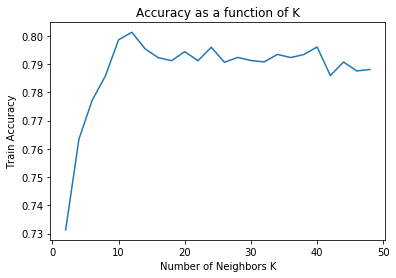

The optimal k value is 12


In [16]:
neighbors = list(filter(lambda x: x % 2 == 0, list(range(1,50))))
cv_scores = []

for kk in neighbors:
    knn = KNeighborsClassifier(n_neighbors=kk,n_jobs=-1,metric='braycurtis')
    scores = cross_val_score(knn, visual_words, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.title('Accuracy as a function of K')
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()
#python2.x
#print("The optimal k value is %d" % optimal_k)
#python3.x
print("The optimal k value is %d" % optimal_k)

We build a k-nn classifier and train it with the train descriptors

In [17]:
folds = skf.split(visual_words, train_labels)
knn = KNeighborsClassifier(n_neighbors=optimal_k,n_jobs=-1,metric='braycurtis')

for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    train_labels=np.asarray(train_labels)

    visual_words_train, visual_words_valid = visual_words[train_idx], visual_words[test_idx]
    labels_train, labels_valid = train_labels[train_idx], train_labels[test_idx]
    knn.fit(visual_words_train, labels_train) 
    accuracy = 100*knn.score(visual_words_valid, labels_valid)
    print(accuracy)
end=time.time()
print('Time: {}s.'.format(str(end-start)))


===================FOLD= 0
76.38668779714739

===================FOLD= 1
79.26634768740031

===================FOLD= 2
77.04654895666133
Time: 29.481048583984375s.


We end up computing the test descriptors and compute the accuracy of the model

In [22]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    kpt,des=descriptors(gray,x)
        
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In the next step we perform the confusion matrix to evaluate our classifier with respect the 8 image classes:

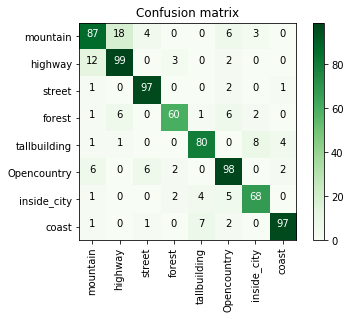

In [23]:
classes = list(set(test_labels))

if(Kernel== 'histogram'):
    predict= histogram_intersection(stdSlr.transform(visual_words_test),scaled)
    predictions= clf.predict(predict)
else:
    predictions= clf.predict(stdSlr.transform(visual_words_test))

conf_matrix= confusion_matrix(test_labels,predictions)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")


In [24]:
#Provisional: I'm trying to perform more evaluation metrics

precision, recall, fscore, support= precision_recall_fscore_support(test_labels, predictions,average='macro')

print (precision*100)
print (recall*100)
print (fscore*100)

85.43309721482692
84.99334045015219
85.12026053051791


Finally, we compute the accuracy for SVM and KNN:

In [25]:
if Kernel == 'histogram':
    accuracy_svm = 100*clf.score(predict, test_labels)
else:
    accuracy_svm = 100*clf.score(stdSlr.transform(visual_words_test), test_labels)
print(accuracy_svm)

85.00619578686494


In [26]:
accuracy_knn = 100*knn.score(visual_words_test, test_labels)
print(accuracy_knn)

80.17348203221809


Finally, in the next tables we summarise all the results that we have obtained changing the different parameters and using different types of feature descriptors:

SIFT:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  53.5315 | 55.8859 | 54.3990 |
| Chebyshev |  43.2465 | 44.6096 | 46.3444 |
| Manhattan |  50.1858 | 52.4163 | 53.4076 |
|  Hamming  |  35.1920 | 37.5464 | 38.16604|
| Canberra  |  50.1858 | 51.6728 | 49.0706 |
|Braycurtis |  57.1250 | 57.6208 | 54.7707 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 54.0272 | 49.3184 | 49.5662 | 
| Chebyshev | 47.4597 | 42.1313 | 42.9987 |
| Manhattan | 53.7794 | 35.3159 | 35.4399 |
|  Hamming  | 42.5030 | 21.6852 | 23.1722 |
| Canberra  | 49.3184 | 47.5836 | 48.5749 | 
|Braycurtis | 55.0185 | 60.5947 | 61.2143 |

SURF:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  54.7707 | 57.0012 | 58.8599 |
| Chebyshev |  46.8401 | 49.5662 | 52.1685 |
| Manhattan |  53.5315 | 53.5315 | 57.8686 |
|  Hamming  |  35.9355 | 37.1747 | 38.7856 |
| Canberra  |  55.7620 | 56.2577 | 56.7534 |
|Braycurtis |  62.5774 | 63.8166 | 61.8339 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 58.6121 | 50.5576 | 50.5576 | 
| Chebyshev | 52.6641 | 47.4597 | 46.2205 |
| Manhattan | 59.1078 | 42.9987 | 43.2465 |
|  Hamming  | 40.6443 | 29.8636 | 31.1028 |
| Canberra  | 56.5055 | 52.4163 | 52.4163 |
|Braycurtis | 61.5861 | 63.5687 | 62.3296 |

ORB:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  32.8376 | 36.4312 | 31.9702 |
| Chebyshev |  25.7744 | 27.7571 | 28.3767 |
| Manhattan |  33.2094 | 38.5377 | 32.4659 |
|  Hamming  |  26.0223 | 29.1201 | 24.4114 |
| Canberra  |  27.8810 | 30.6071 | 27.8810 |
|Braycurtis |  32.4659 | 32.4659 | 30.6071 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 35.1920 | 34.6964 | 36.0594 | 
| Chebyshev | 26.2701 | 24.0396 | 23.7918 |
| Manhattan | 36.6790 | 27.8810 | 29.1201 |
|  Hamming  | 28.2527 | 20.8178 | 19.3308 |
| Canberra  | 30.8550 | 31.2267 | 33.3333 |
|Braycurtis | 31.2267 | 31.9702 | 31.2267 |

Dense SURF:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  62.0817 | 63.9405 |61.8339|
| Chebyshev |  54.0272 | 54.1511 |57.8686|
| Manhattan |  64.9318 | 64.9318 |62.4535|
|  Hamming  |  42.0074 | 49.8141 |39.9008|
| Canberra  |  63.4448 | 63.9405 |63.8166|
|Braycurtis |  64.9318 | 65.1796 |62.8252|

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 61.8339 | 64.6840 | 64.1883 | 
| Chebyshev | 57.8686 | 55.8859 | 52.5402 |
| Manhattan | 63.9405 | 67.4101 | 66.2949 |
|  Hamming  | 44.1140 | 50.8054 | 53.5315 |
| Canberra  | 64.1883 | 62.2057 | 63.4448 |
|Braycurtis | 63.5687 | 67.1623 | 66.4188 |

Dense SIFT:

| Distance | Kbatch=128,Initial parameters | Kbatch=128,Optimal K |K=64,Initial parameters |
| --- | --- | --- | --- |
| Euclidean |  70.1363 | 72.7385 | 69.7645 |
| Chebyshev |  58.7360 | 58.8599 | 58.9838 | 
| Manhattan |  76.7038 | 78.3147 | 73.3581 | 
|  Hamming  |  36.3073 | 38.6617 | 40.5204 |
| Canberra  |  74.2255 | 75.4646 | 71.1276 |
|Braycurtis |  76.7038 | 78.3147 | 73.6059 |

| Distance | Kbatch=64,Optimal K| Kbatch=256,Initial parameters | KBatch=256,Optimal K| 
| --- | --- | --- | --- |
| Euclidean | 73.1102  | 71.6232 | 71.3754 |
| Chebyshev | 62.7013  | 54.8946 | 53.5315 |
| Manhattan | 75.8364  | 79.9256 | 81.1648 |
|  Hamming  | 37.7942  | 36.9268 | 37.0508 |
| Canberra  | 74.1016  | 76.7038 | 78.0669 |
|Braycurtis | 75.8364  | 79.5539 | 81.0408 |














As we can see in our results, we have achieved to improve the initial acurracy of 53.53 almost 30% more. The best result is using the dense SIFT, a codebook size of 256 and the Manhattan (or Braycurtis 81.0408 %) distance where we obtain a 81.1648 % of accuracy.

During this first lab we can conclude that:

- Respect to the feature descriptors, we see a slightly improvement using SURF respect SIFT. Despite this, in the dense version we have the better results, specially, in dense SIFT. The ORB descriptor tends to get worse the results respect SIFT and SURF.

- Respect to the codebook size, we can see that using a size of 256 we achieved to slightly improve the accuracy.  However, the computational cost increase a lot at same time that we increase the size.

- Respect to the knn distance, from the 6 distances that we have tested, Braycurtis and Manhanttan distances provided us the best results. In the other hand, we have the Chebyshev and Hamming distance where we obtained the lowest accuracy.

- Respect to the number of neighbors, we can see that choosing the optimal k value the accuracy can increase until 5% more than using the initial parameter.







